Here's a detailed, step-by-step guide to a comprehensive imputation strategy that incorporates group-based approaches, multi-phase imputation, and takes into account both the correlation among the variables and the correlation in their missingness:

### Step 1: Data Preparation and Initial Analysis
**Objective**: Prepare the dataset for imputation and understand its structure and missingness patterns.
- **Correlation Analysis**: Conduct a correlation analysis among variables to identify groups of highly correlated variables (e.g., correlation > 0.5). Also, examine the correlation of missingness—determine if the missingness in one variable correlates with missingness in another (correlation of missing data patterns).
- **Analyze Missingness**: Use tools like `missingno` or Pandas' `isna()` to analyze the pattern of missingness. Check both the amount and the pattern of missing data in each column.

### Step 2: Group-Based Imputation for Highly Correlated Variables
**Objective**: Address missing values within groups of highly correlated variables using targeted imputation strategies.
- **Form Groups**: Based on the correlation analysis, form groups of variables that are highly correlated.
- **Initial Imputation Within Groups**: For each group, perform an initial simple imputation (mean, median, or mode) to stabilize the dataset for more complex operations.
- **Predictive Imputation**: Apply predictive imputation techniques within each group. Use regression models or classifiers (like RandomForest or Gradient Boosting Machines) depending on the nature of the data (continuous vs. categorical). Each variable within a group can potentially serve as a predictor for the others.

### Step 3: Handling Simultaneous Missingness
**Objective**: Address the variables that exhibit high correlations in their missingness patterns, even if their data values are not correlated.
- **Identify Simultaneous Missingness Patterns**: Determine which variables often miss together (correlation of missingness ≥ 0.7).
- **Segmented Imputation Strategy**: Apply imputation strategies tailored to these patterns. For example, if two variables are often missing together but are not correlated in their values, use more generalized imputation methods like iterative imputation to estimate their values.

### Step 4: Comprehensive Iterative Imputation
**Objective**: Perform a comprehensive, dataset-wide imputation to refine and harmonize all earlier imputations and to handle any remaining missing values.
- **Apply Iterative Imputation**: Use `IterativeImputer` or a similar technique to impute any remaining missing values across the dataset. This method iteratively models each feature with missing values as a function of other features in a round-robin fashion.
- **Refinement and Validation**: This step refines the imputations made in the earlier phases by leveraging interdependencies across the entire dataset. Validate the imputed values by checking summary statistics and distributions before and after imputation to ensure that the imputation process has not introduced biases.

### Step 5: Final Review and Integration
**Objective**: Ensure the integrity and usability of the imputed dataset.
- **Review and Adjust**: Examine the imputed dataset for any inconsistencies or anomalies. Adjust if necessary by revisiting any of the previous steps.
- **Integration into Analysis Pipeline**: Integrate the imputed dataset into your subsequent analysis or modeling pipeline. Perform tests such as predictive modeling or statistical analysis to ensure that the imputation has adequately supported the dataset's intended use.

### Conclusion
This structured approach to handling missing data ensures that each variable and its missingness are addressed thoughtfully, based on the underlying data relationships and patterns. By combining group-based, phase-wise, and comprehensive imputation strategies, the quality and reliability of the dataset are enhanced, making it robust for high-stakes analysis and decision-making.

------------------------------------------------------------------------------------------------------------------

### Step 1: Data Preparation and Initial Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
encoded_train_df = pd.read_csv('encoded_train_df.csv').drop(columns='Unnamed: 0', axis=1)
encoded_test_df = pd.read_csv('encoded_test_df.csv').drop(columns='Unnamed: 0', axis=1)

In [3]:
encoded_train_df

,ID,Gender,Customer_Type,Age,Type_Travel,Travel_Class,Travel_Distance,Departure_Delay_in_Mins,Arrival_Delay_in_Mins,Overall_Experience,...,Onboard_Wifi_Service,Onboard_Entertainment,Online_Support,Ease_of_Online_Booking,Onboard_Service,Legroom,Baggage_Handling,CheckIn_Service,Cleanliness,Online_Boarding
0,98800001,0.0,1.0,52.0,NaN,0,272,0.0,5.0,0,...,4.0,2.0,3.0,2.0,2.0,3.0,2.0,4.0,2.0,1.0
1,98800002,1.0,1.0,48.0,1.0,1,2200,9.0,0.0,0,...,4.0,1.0,4.0,4.0,5.0,2.0,1.0,2.0,4.0,4.0
2,98800003,0.0,1.0,43.0,0.0,0,1061,77.0,119.0,1,...,2.0,4.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0,5.0
3,98800004,0.0,1.0,44.0,0.0,0,780,13.0,18.0,0,...,3.0,2.0,3.0,3.0,3.0,3.0,3.0,4.0,3.0,3.0
4,98800005,0.0,1.0,50.0,0.0,0,1981,0.0,0.0,1,...,2.0,4.0,5.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94374,98894375,1.0,1.0,32.0,0.0,0,1357,83.0,125.0,0,...,1.0,1.0,1.0,1.0,4.0,4.0,4.0,2.0,4.0,1.0
94375,98894376,1.0,1.0,44.0,0.0,0,592,5.0,11.0,1,...,2.0,5.0,5.0,3.0,3.0,3.0,3.0,4.0,3.0,4.0
94376,98894377,1.0,NaN,63.0,0.0,0,2794,0.0,0.0,1,...,4.0,5.0,4.0,4.0,4.0,4.0,4.0,3.0,4.0,3.0
94377,98894378,1.0,1.0,16.0,1.0,1,2744,0.0,0.0,0,...,4.0,2.0,4.0,4.0,3.0,4.0,4.0,4.0,5.0,4.0


In [4]:
encoded_test_df

,ID,Gender,Customer_Type,Age,Type_Travel,Travel_Class,Travel_Distance,Departure_Delay_in_Mins,Arrival_Delay_in_Mins,Seat_Comfort,...,Onboard_Wifi_Service,Onboard_Entertainment,Online_Support,Ease_of_Online_Booking,Onboard_Service,Legroom,Baggage_Handling,CheckIn_Service,Cleanliness,Online_Boarding
0,99900001,0.0,NaN,36.0,0.0,0,532,0.0,0.0,3.0,...,2.0,5.0,4.0,5.0,5.0,5.0,5.0,4.0,5.0,1.0
1,99900002,0.0,0.0,21.0,0.0,0,1425,9.0,28.0,0.0,...,3.0,1.0,3.0,3.0,5.0,3.0,4.0,3.0,5.0,3.0
2,99900003,1.0,1.0,60.0,0.0,0,2832,0.0,0.0,5.0,...,5.0,5.0,5.0,2.0,2.0,2.0,2.0,4.0,2.0,5.0
3,99900004,0.0,1.0,29.0,1.0,1,1352,0.0,0.0,3.0,...,1.0,3.0,5.0,1.0,3.0,2.0,5.0,5.0,5.0,1.0
4,99900005,1.0,0.0,18.0,0.0,0,1610,17.0,0.0,5.0,...,5.0,5.0,5.0,5.0,NaN,3.0,5.0,5.0,5.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35597,99935598,1.0,1.0,8.0,1.0,1,1334,0.0,0.0,2.0,...,3.0,2.0,3.0,3.0,4.0,5.0,4.0,3.0,4.0,3.0
35598,99935599,0.0,1.0,53.0,0.0,0,1772,0.0,0.0,2.0,...,3.0,5.0,5.0,4.0,4.0,4.0,4.0,3.0,4.0,4.0
35599,99935600,1.0,0.0,22.0,0.0,1,1180,0.0,0.0,4.0,...,2.0,4.0,1.0,2.0,1.0,3.0,1.0,1.0,5.0,2.0
35600,99935601,0.0,1.0,67.0,1.0,1,420,23.0,16.0,5.0,...,3.0,5.0,4.0,5.0,5.0,5.0,5.0,3.0,5.0,4.0


In [5]:
encoded_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94379 entries, 0 to 94378
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       94379 non-null  int64  
 1   Gender                   94302 non-null  float64
 2   Customer_Type            85428 non-null  float64
 3   Age                      94346 non-null  float64
 4   Type_Travel              85153 non-null  float64
 5   Travel_Class             94379 non-null  int64  
 6   Travel_Distance          94379 non-null  int64  
 7   Departure_Delay_in_Mins  94322 non-null  float64
 8   Arrival_Delay_in_Mins    94022 non-null  float64
 9   Overall_Experience       94379 non-null  int64  
 10  Seat_Comfort             94318 non-null  float64
 11  Seat_Class               94379 non-null  int64  
 12  Arrival_Time_Convenient  85449 non-null  float64
 13  Catering                 85638 non-null  float64
 14  Platform_Location     

In [6]:
encoded_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35602 entries, 0 to 35601
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       35602 non-null  int64  
 1   Gender                   35572 non-null  float64
 2   Customer_Type            32219 non-null  float64
 3   Age                      35591 non-null  float64
 4   Type_Travel              32154 non-null  float64
 5   Travel_Class             35602 non-null  int64  
 6   Travel_Distance          35602 non-null  int64  
 7   Departure_Delay_in_Mins  35573 non-null  float64
 8   Arrival_Delay_in_Mins    35479 non-null  float64
 9   Seat_Comfort             35580 non-null  float64
 10  Seat_Class               35602 non-null  int64  
 11  Arrival_Time_Convenient  32277 non-null  float64
 12  Catering                 32245 non-null  float64
 13  Platform_Location        35590 non-null  float64
 14  Onboard_Wifi_Service  

**Correlation Analysis** 

In [7]:
encoded_train_df_copy = encoded_train_df.copy()

# Drop the 'ID' column as it's typically a unique identifier not useful for correlation analysis
encoded_train_df_copy.drop('ID', axis=1, inplace=True)

# Impute missing numerical data (optional, simple median imputation for demonstration)
for column in encoded_train_df_copy.select_dtypes(include=np.number).columns:
    encoded_train_df_copy[column].fillna(encoded_train_df_copy[column].median(), inplace=True)

# Calculate the correlation matrix
correlation_matrix_train = encoded_train_df_copy.corr()

# Print the correlation matrix
correlation_matrix_train


,Gender,Customer_Type,Age,Type_Travel,Travel_Class,Travel_Distance,Departure_Delay_in_Mins,Arrival_Delay_in_Mins,Overall_Experience,Seat_Comfort,...,Onboard_Wifi_Service,Onboard_Entertainment,Online_Support,Ease_of_Online_Booking,Onboard_Service,Legroom,Baggage_Handling,CheckIn_Service,Cleanliness,Online_Boarding
Gender,1.000000,0.027860,0.005040,0.011197,-0.009196,0.126043,0.002216,0.000257,-0.214417,-0.072147,...,-0.032139,-0.142193,-0.091215,-0.083109,-0.055545,-0.071713,-0.014813,-0.016203,-0.015903,-0.047199
Customer_Type,0.027860,1.000000,0.265036,0.270239,-0.078608,-0.018999,-0.002844,-0.004245,0.274699,0.035775,...,0.070744,0.218200,0.174062,0.142737,0.075907,0.091651,-0.001716,0.038913,0.002041,0.101913
Age,0.005040,0.265036,1.000000,-0.040190,-0.136799,-0.251518,-0.007987,-0.010641,0.116212,0.007996,...,0.011522,0.131475,0.117289,0.068904,0.060750,0.082694,-0.018021,0.028649,-0.018462,0.035591
Type_Travel,0.011197,0.270239,-0.040190,1.000000,0.512995,-0.114299,-0.008244,-0.008299,-0.100799,0.013539,...,-0.014307,-0.074647,-0.031940,-0.021881,0.034940,0.011371,0.046256,0.054448,0.055427,-0.004760
Travel_Class,-0.009196,-0.078608,-0.136799,0.512995,1.000000,-0.165618,0.007354,0.012299,-0.310013,0.032533,...,-0.061263,-0.247824,-0.182712,-0.132344,-0.158326,-0.132137,-0.128855,-0.139706,-0.123300,-0.100697
Travel_Distance,0.126043,-0.018999,-0.251518,-0.114299,-0.165618,1.000000,0.114078,0.110896,-0.041582,-0.045098,...,0.010124,-0.028173,-0.033172,-0.023005,-0.032879,-0.030420,0.019181,0.002586,0.007209,0.006164
Departure_Delay_in_Mins,0.002216,-0.002844,-0.007987,-0.008244,0.007354,0.114078,1.000000,0.958940,-0.073810,-0.025193,...,-0.032534,-0.030393,-0.033302,-0.036970,-0.034755,0.000403,-0.012738,-0.021171,-0.066798,-0.019975
Arrival_Delay_in_Mins,0.000257,-0.004245,-0.010641,-0.008299,0.012299,0.110896,0.958940,1.000000,-0.080027,-0.026775,...,-0.035000,-0.033054,-0.035585,-0.040125,-0.037444,-0.002878,-0.017654,-0.024411,-0.071894,-0.021902
Overall_Experience,-0.214417,0.274699,0.116212,-0.100799,-0.310013,-0.041582,-0.073810,-0.080027,1.000000,0.243357,...,0.229621,0.524749,0.391825,0.432110,0.334353,0.302461,0.257585,0.262505,0.255596,0.339148
Seat_Comfort,-0.072147,0.035775,0.007996,0.013539,0.032533,-0.045098,-0.025193,-0.026775,0.243357,1.000000,...,0.127747,0.425321,0.117952,0.209756,0.119390,0.136670,0.118228,0.041175,0.108168,0.128689


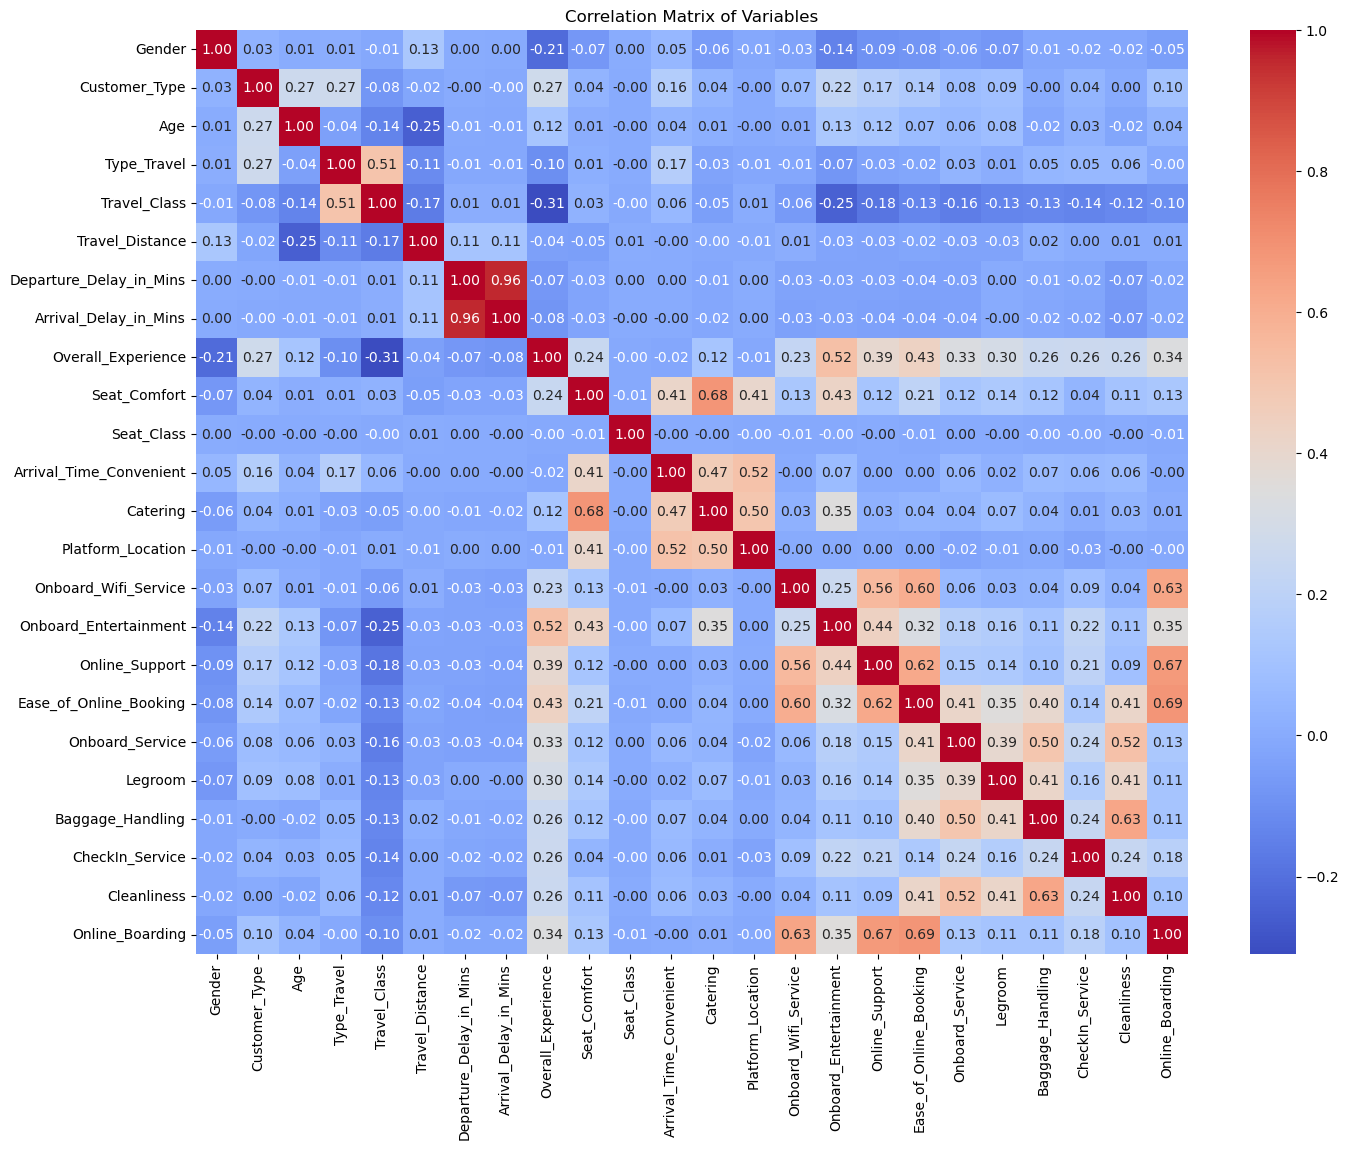

In [8]:
# Plotting the heatmap of the correlation matrix
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix_train, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of Variables')
plt.show()


**Analyzing Missingness**

In [9]:
!pip install missingno

<Figure size 1200x600 with 0 Axes>

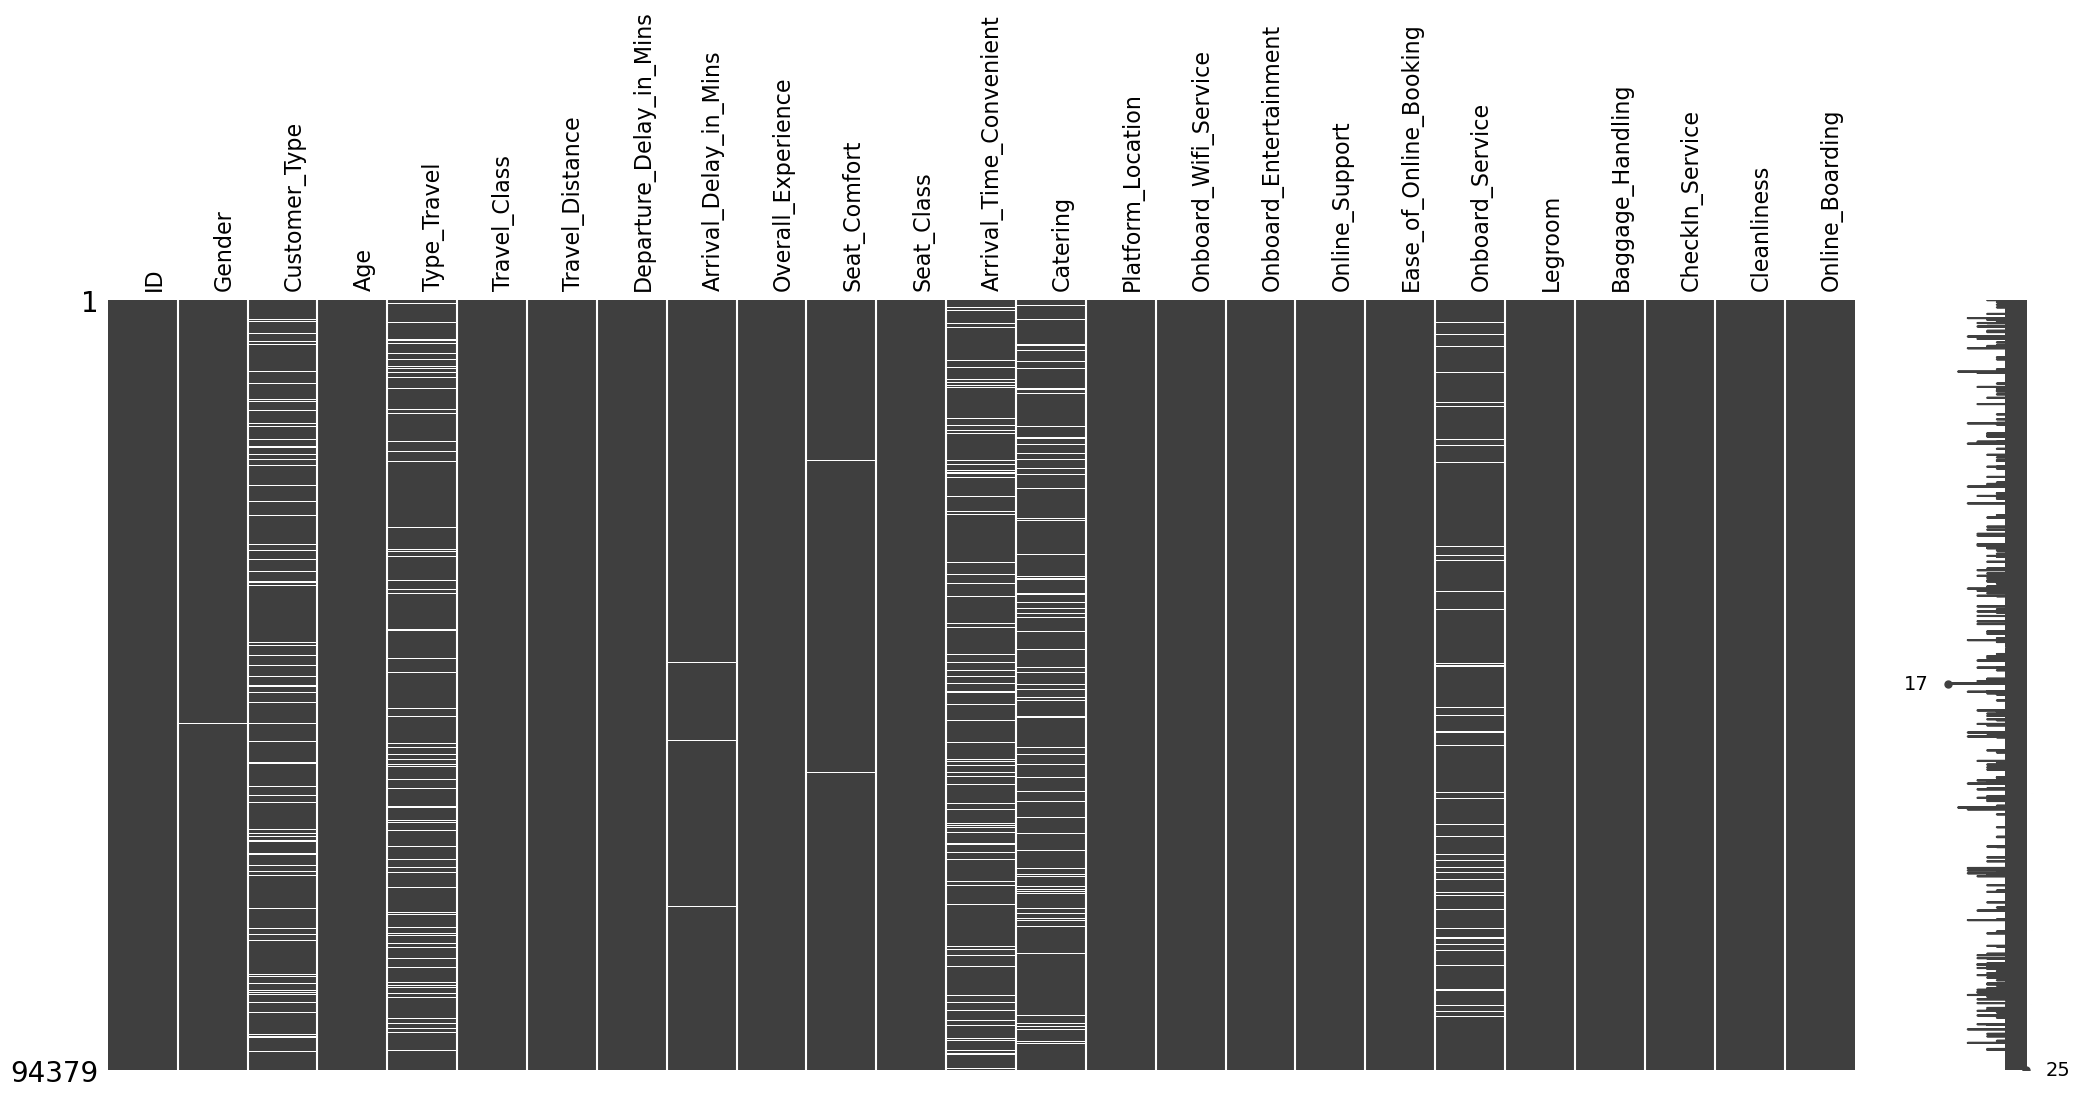

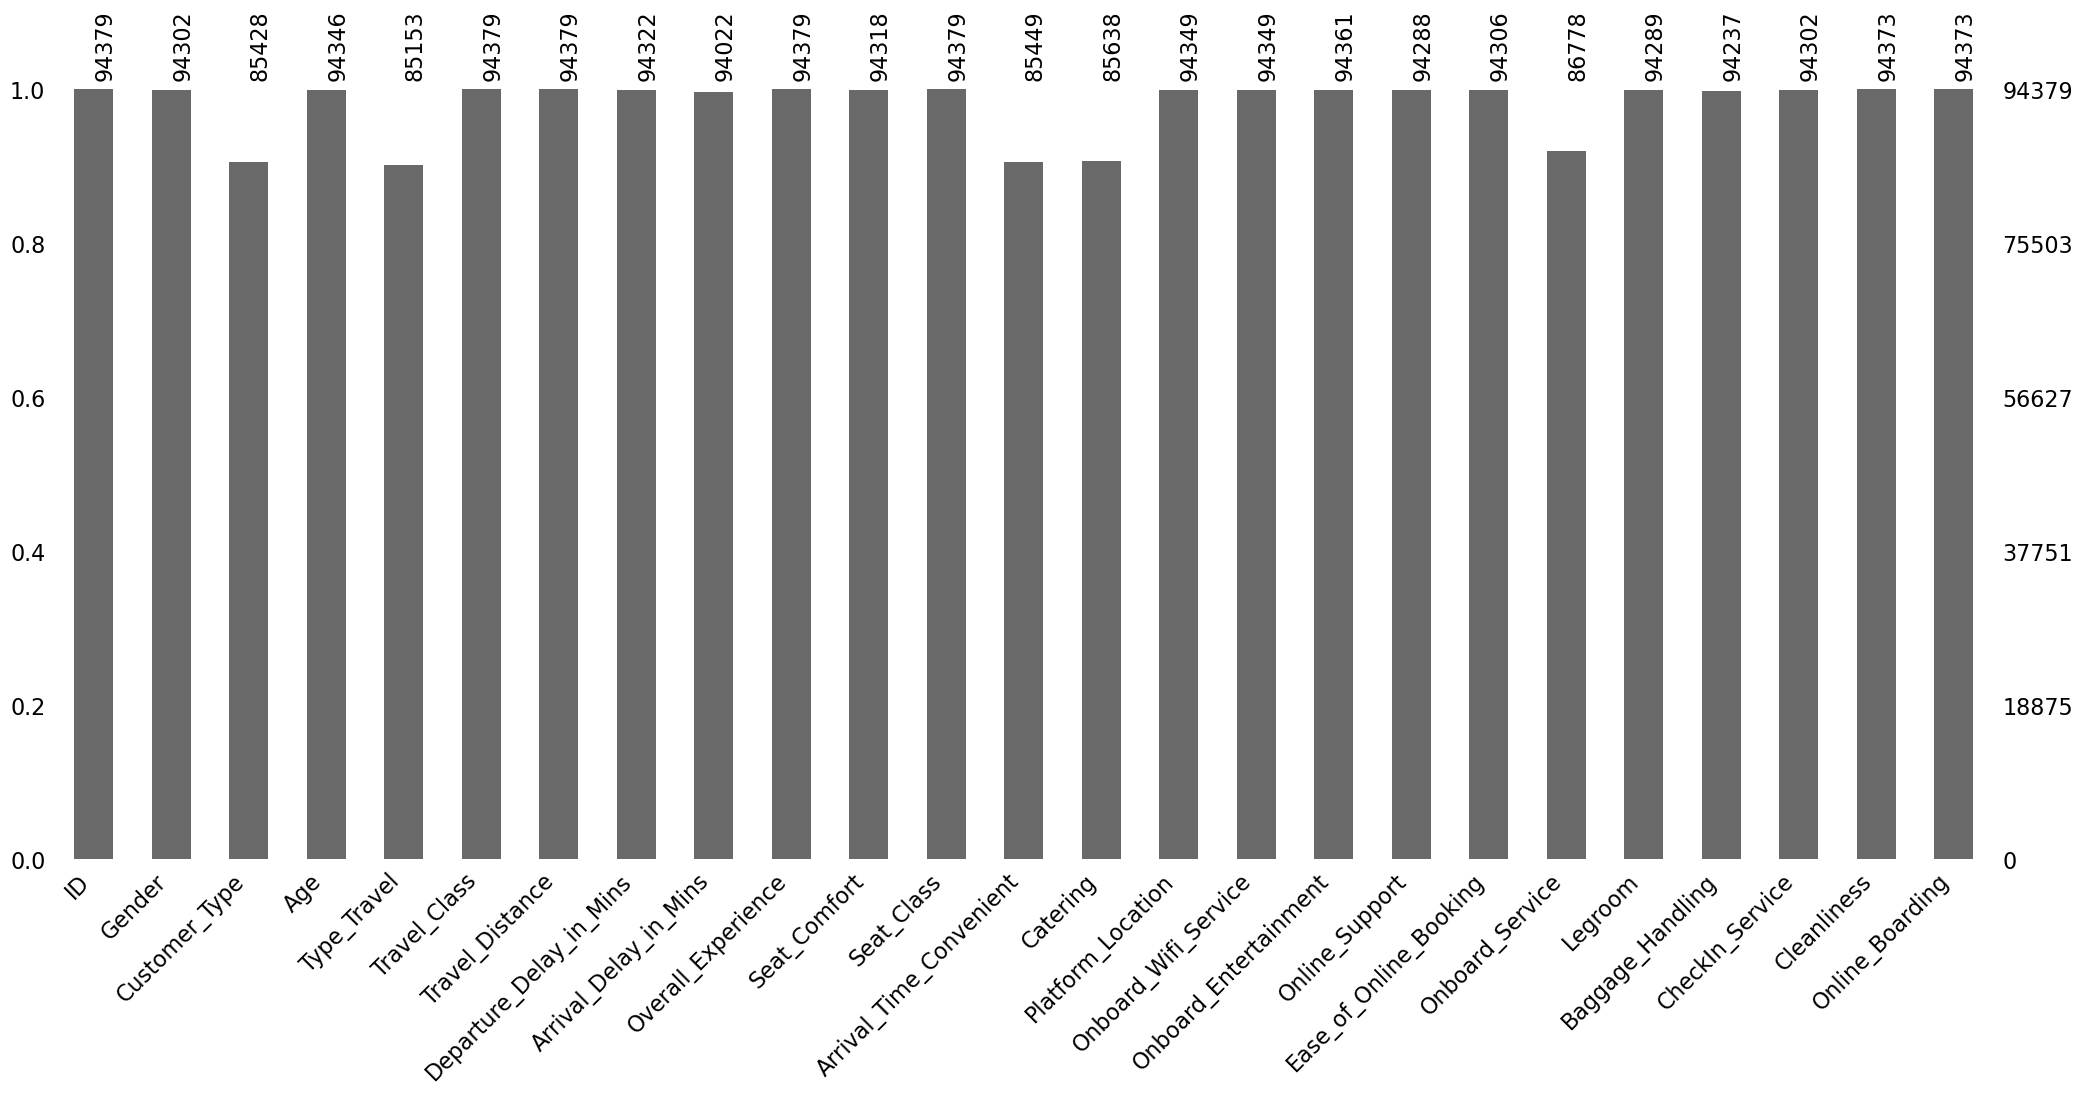

<Figure size 1200x600 with 0 Axes>

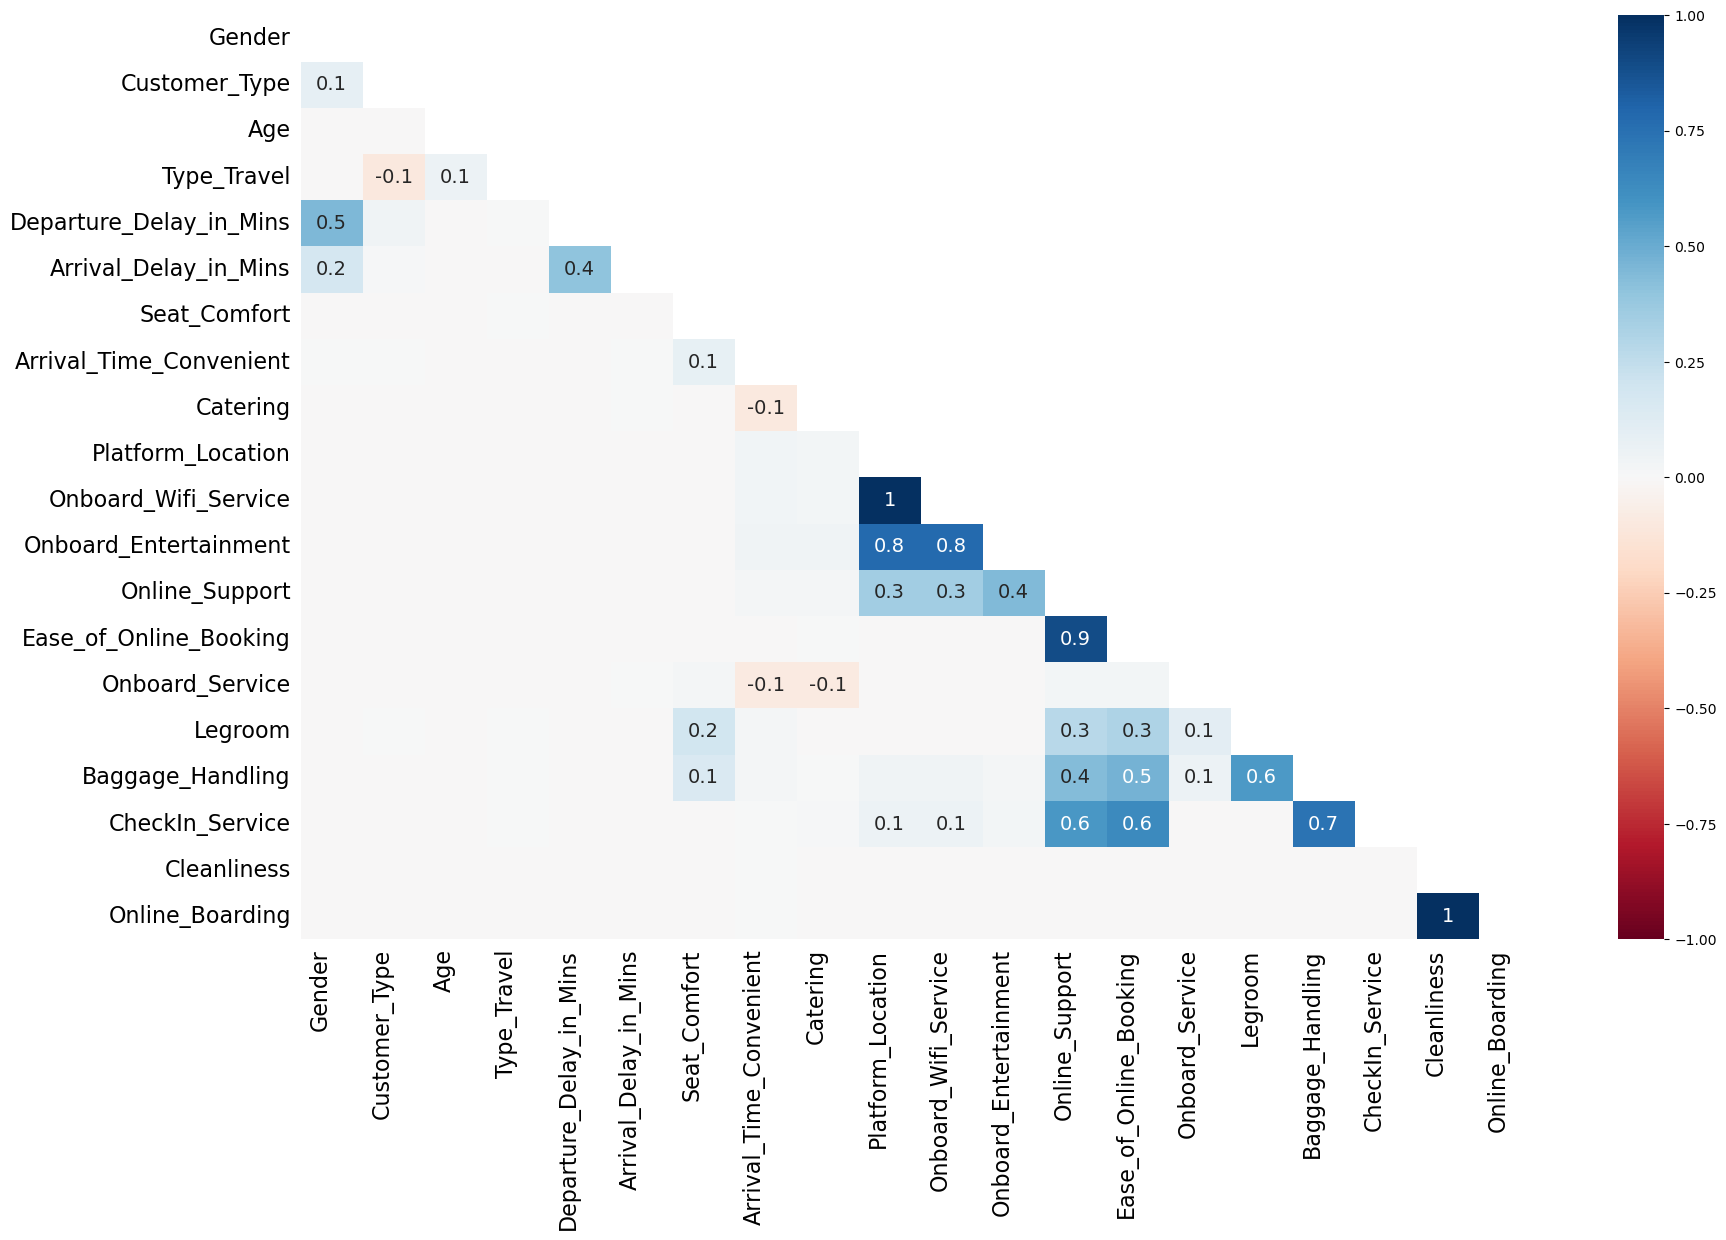

In [10]:
import missingno as msno

# Visualizing the missing values using a matrix
plt.figure(figsize=(12,6))  # Adjust the size as needed
msno.matrix(encoded_train_df)
plt.xticks(rotation=90)  # Rotate x-axis labels to 90 degrees
plt.show()  # Display the plot

# Additionally, to see a bar chart of missing values
plt.figure(figsize=(12,6))  # Adjust the size as needed
msno.bar(encoded_train_df)
plt.xticks(rotation=90)  # Rotate x-axis labels to 90 degrees
plt.show()  # Display the plot

# To analyze the nullity correlation (how strongly the presence or absence of one variable affects the presence of another)
plt.figure(figsize=(12,6))  # Adjust the size as needed
msno.heatmap(encoded_train_df)
plt.xticks(rotation=90)  # Rotate x-axis labels to 90 degrees
plt.show()  # Display the plot

In [11]:
# Calculate the number of missing values for each ID
missing_data_per_id = encoded_train_df.isnull().groupby(encoded_train_df['ID']).sum()

# Adding a total missing count per ID
missing_data_per_id['total_missing'] = missing_data_per_id.sum(axis=1)

# Sort the data by 'total_missing' to see IDs with the most missing data
sorted_missing_data = missing_data_per_id.sort_values(by='total_missing', ascending=False)

# Calculate the total entries for each ID
total_entries_per_id = encoded_train_df.groupby('ID').size()

# Calculate the proportion of missing data
proportion_missing = missing_data_per_id['total_missing'] / total_entries_per_id

# Display the IDs with the highest proportion of missing data
print(proportion_missing.sort_values(ascending=False).head())



ID
98847007    8.0
98808776    7.0
98862202    7.0
98805913    6.0
98853501    6.0
dtype: float64


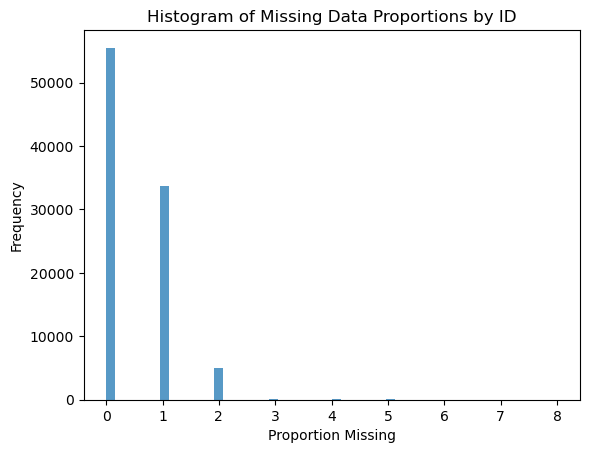

In [12]:
# For a large number of IDs, consider using a histogram or scatter plot instead
plt.hist(proportion_missing, bins=50, alpha=0.75)
plt.title('Histogram of Missing Data Proportions by ID')
plt.xlabel('Proportion Missing')
plt.ylabel('Frequency')
plt.show()


In [13]:
# Calculate the IQR for detection of outliers
Q1 = proportion_missing.quantile(0.25)
Q3 = proportion_missing.quantile(0.75)
IQR = Q3 - Q1

# Define outliers as those beyond 1.5 times the IQR from the Q1 or Q3
outlier_ids = proportion_missing[(proportion_missing < (Q1 - 1.5 * IQR)) | (proportion_missing > (Q3 + 1.5 * IQR))]

print(outlier_ids)


ID
98800014    4.0
98800266    3.0
98800573    3.0
98800902    3.0
98801709    4.0
           ... 
98890253    4.0
98890801    3.0
98891056    6.0
98891806    4.0
98891916    4.0
Length: 264, dtype: float64


In [14]:
# Elimiate the outlier ids 

# Convert outlier_ids to a list if it's not already
outlier_ids = outlier_ids.index.tolist() if isinstance(outlier_ids, pd.Series) else outlier_ids

# Filter the DataFrame to exclude rows where the ID is in the outlier_ids list
filtered_train_df = encoded_train_df[~encoded_train_df['ID'].isin(outlier_ids)]

# Now 'filtered_df' contains only the data excluding the outlier IDs
print(f"Original DataFrame size: {encoded_train_df.shape}")
print(f"Filtered DataFrame size: {filtered_train_df.shape}")

Original DataFrame size: (94379, 25)
Filtered DataFrame size: (94115, 25)


<Figure size 1200x600 with 0 Axes>

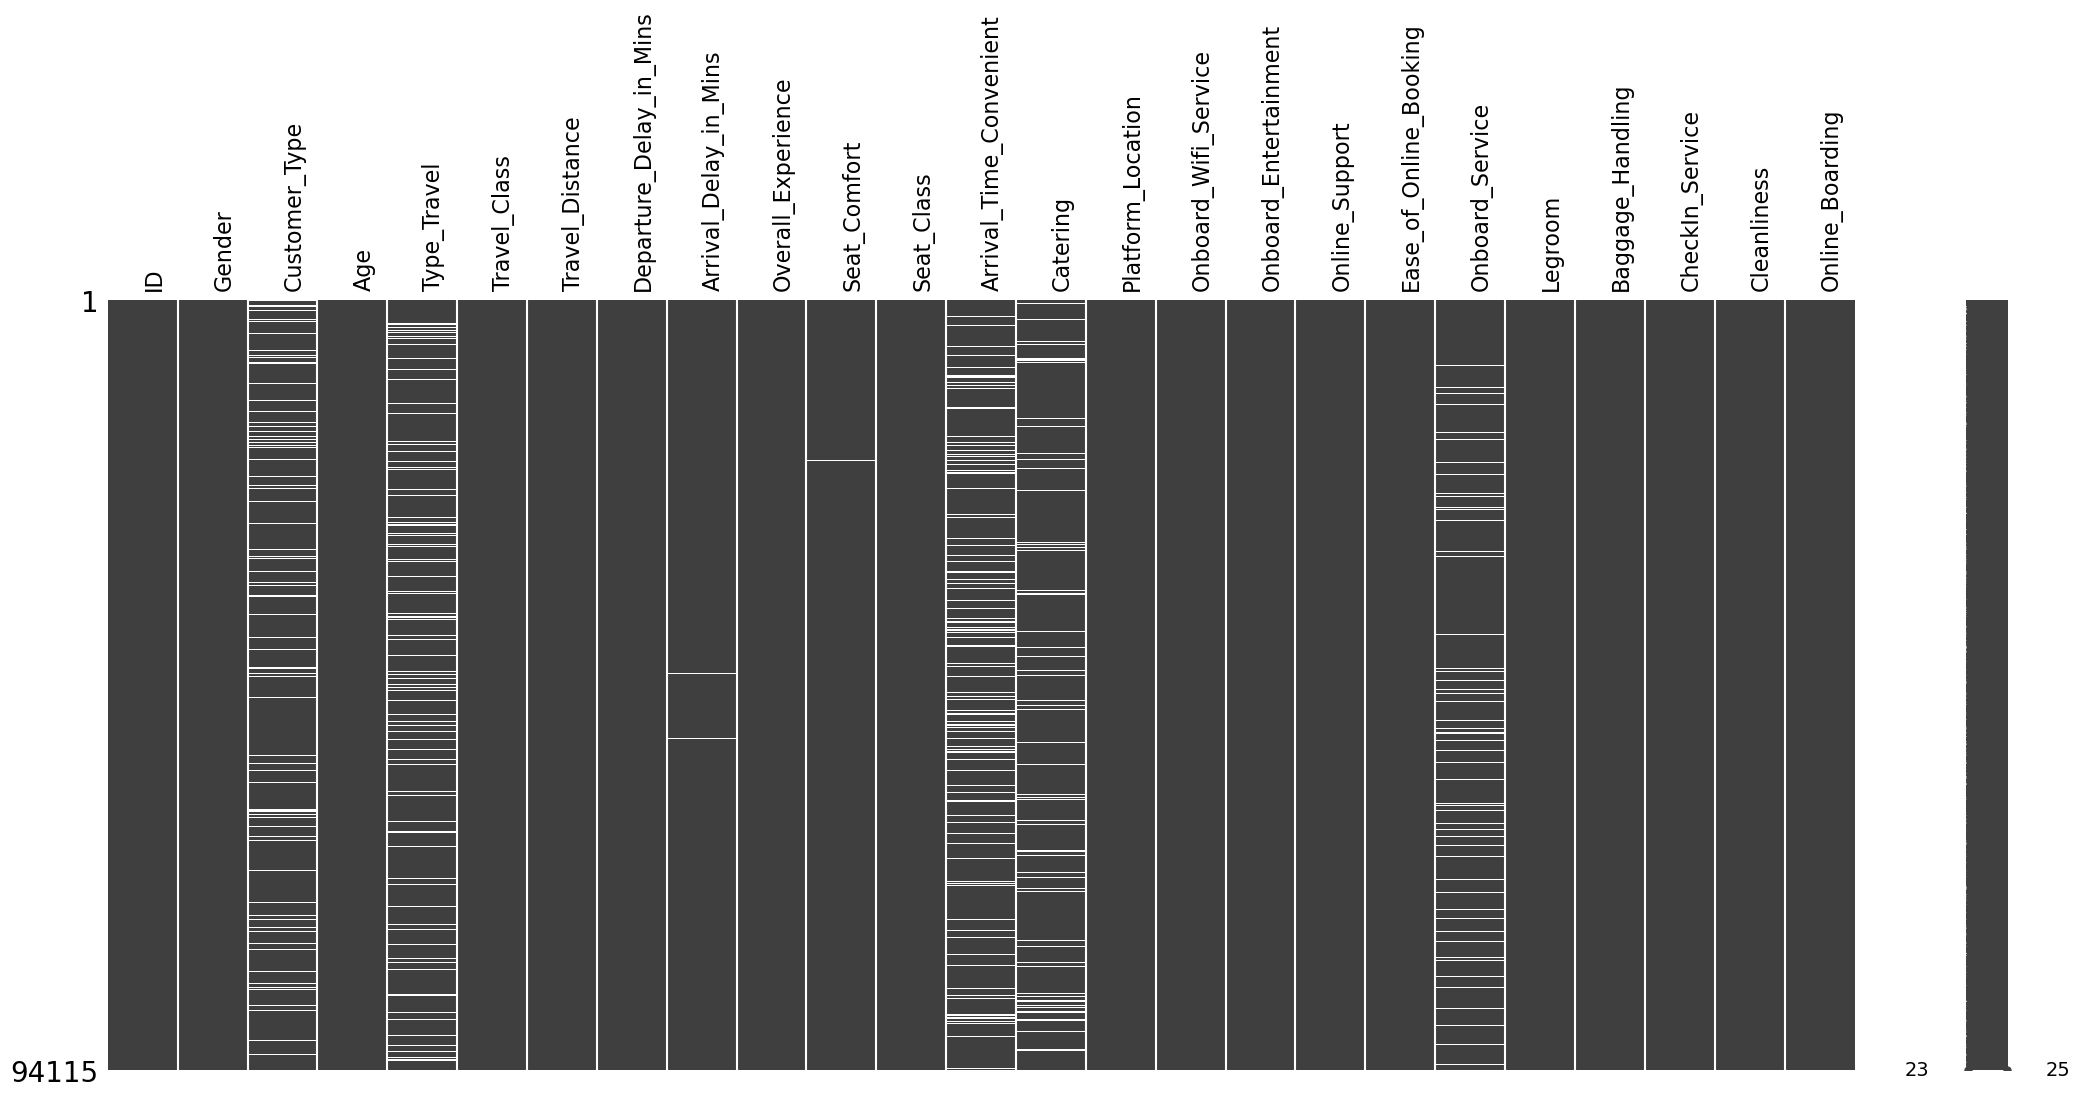

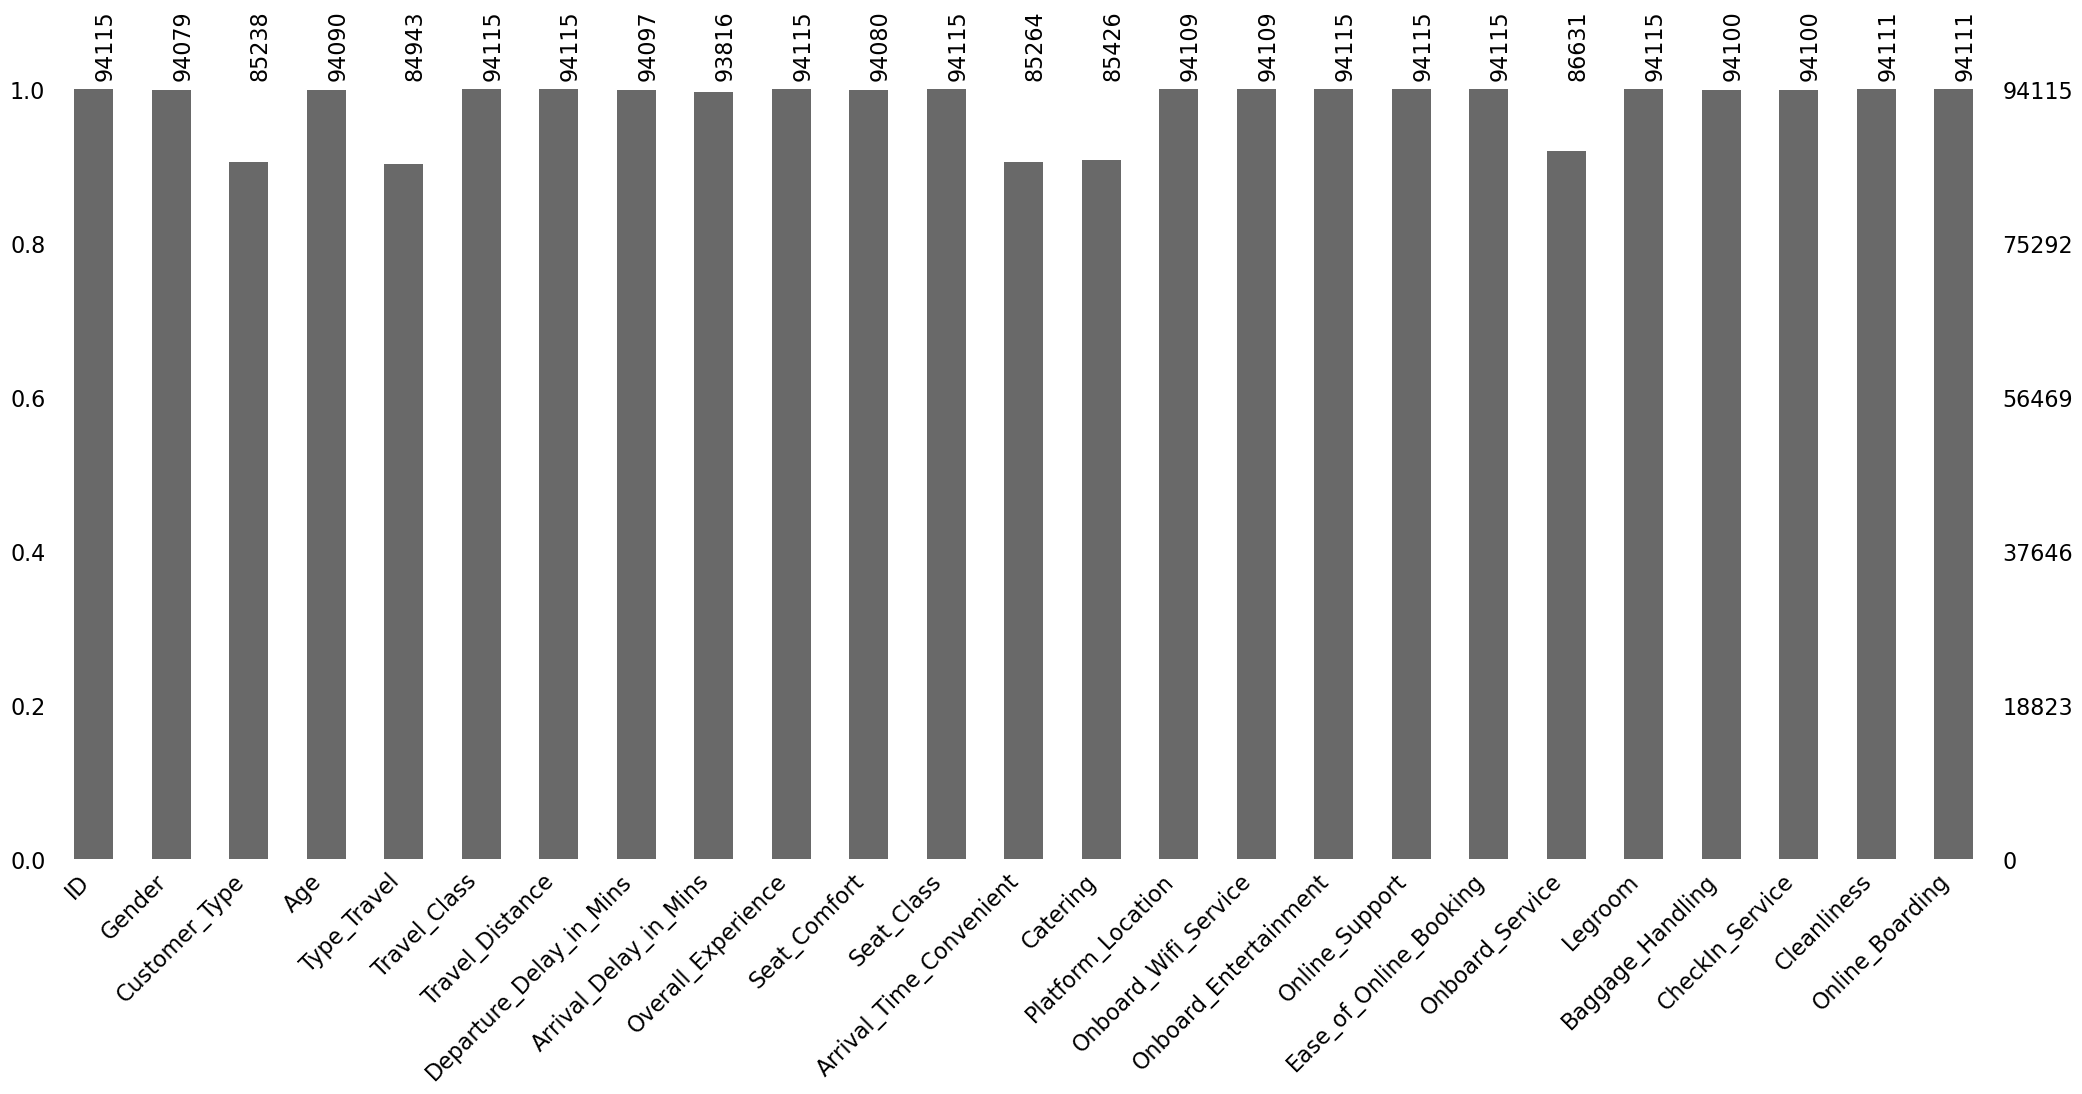

<Figure size 1200x600 with 0 Axes>

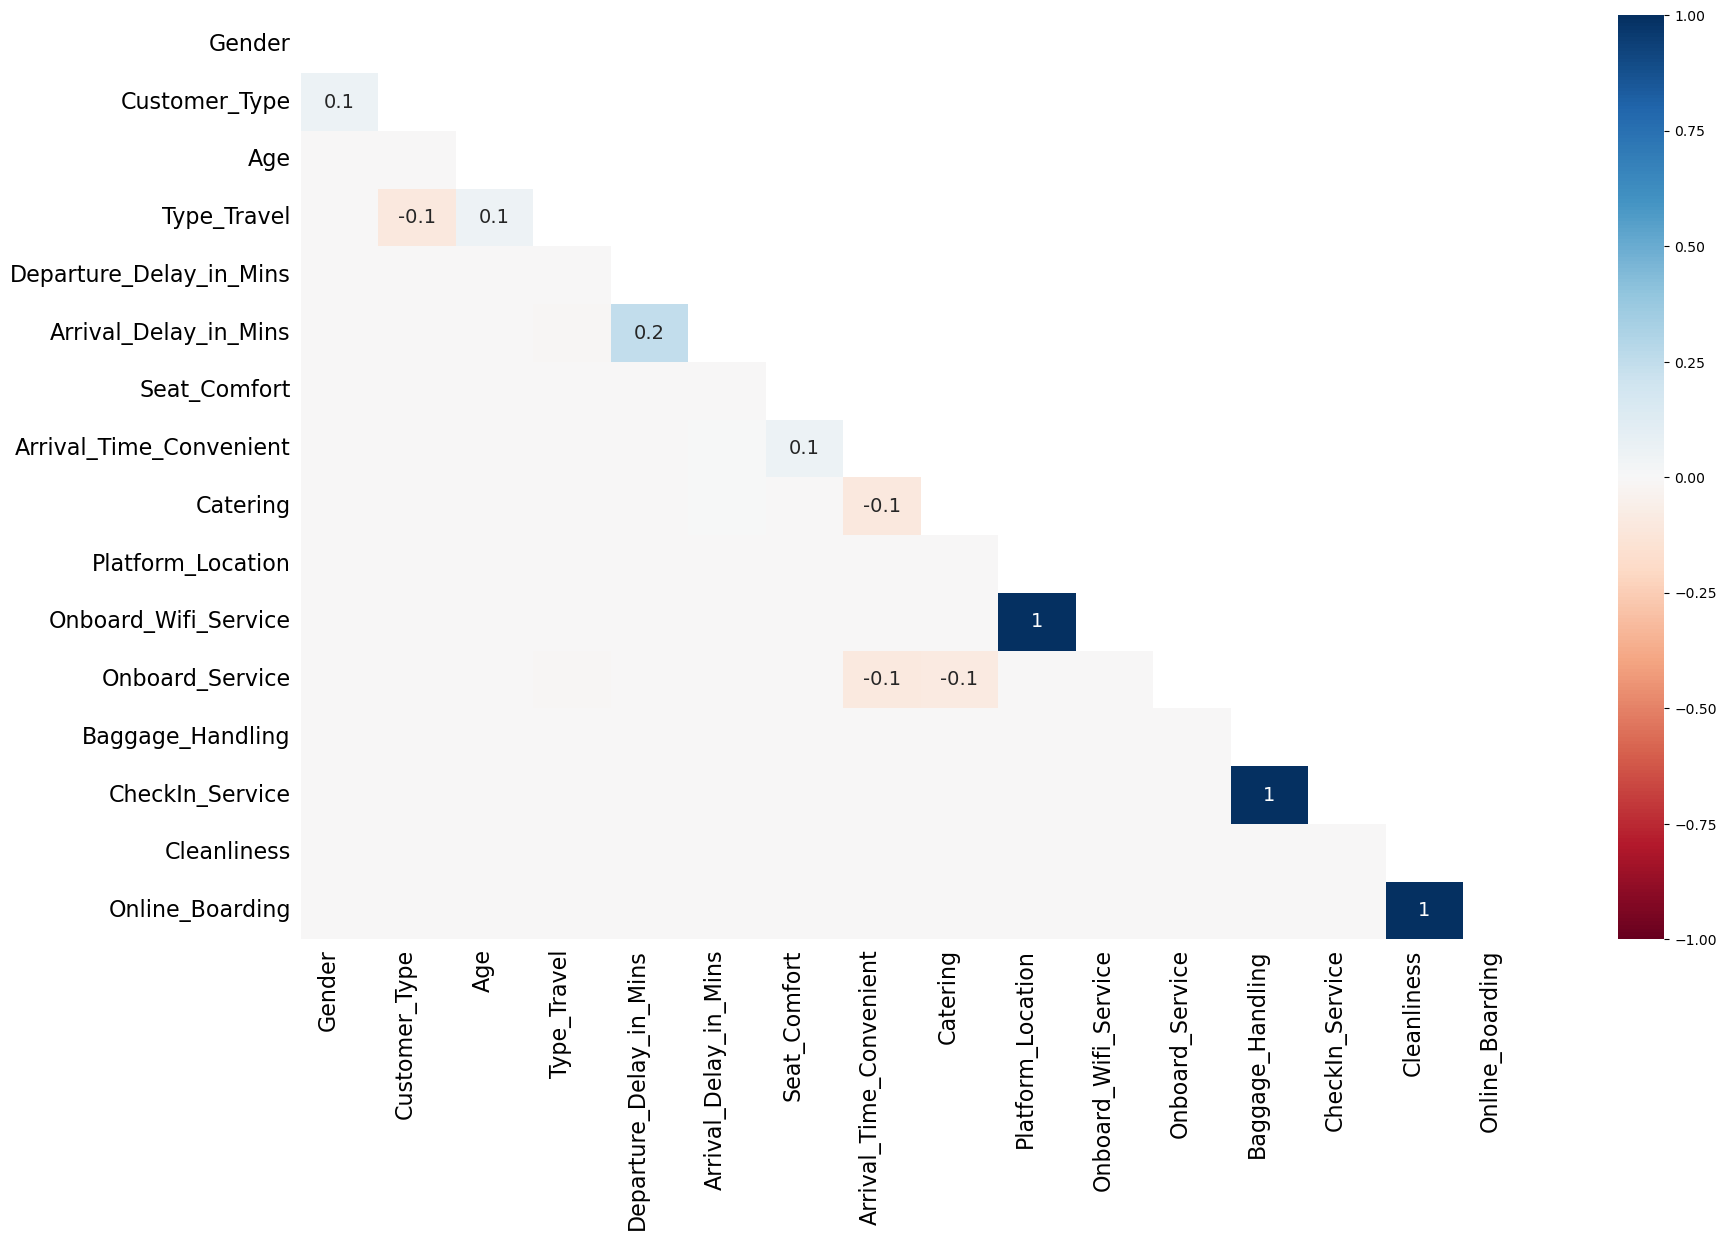

In [15]:
# Look at the missing values for filtered_train_df
# Visualizing the missing values using a matrix
plt.figure(figsize=(12,6))  # Adjust the size as needed
msno.matrix(filtered_train_df)
plt.xticks(rotation=90)  # Rotate x-axis labels to 90 degrees
plt.show()  # Display the plot

# Additionally, to see a bar chart of missing values
plt.figure(figsize=(12,6))  # Adjust the size as needed
msno.bar(filtered_train_df)
plt.xticks(rotation=90)  # Rotate x-axis labels to 90 degrees
plt.show()  # Display the plot

# To analyze the nullity correlation (how strongly the presence or absence of one variable affects the presence of another)
plt.figure(figsize=(12,6))  # Adjust the size as needed
msno.heatmap(filtered_train_df)
plt.xticks(rotation=90)  # Rotate x-axis labels to 90 degrees
plt.show()  # Display the plot

In [16]:
# Check the number of missing values in filtered_train_df
filtered_train_df.isna().sum()

ID                            0
Gender                       36
Customer_Type              8877
Age                          25
Type_Travel                9172
Travel_Class                  0
Travel_Distance               0
Departure_Delay_in_Mins      18
Arrival_Delay_in_Mins       299
Overall_Experience            0
Seat_Comfort                 35
Seat_Class                    0
Arrival_Time_Convenient    8851
Catering                   8689
Platform_Location             6
Onboard_Wifi_Service          6
Onboard_Entertainment         0
Online_Support                0
Ease_of_Online_Booking        0
Onboard_Service            7484
Legroom                       0
Baggage_Handling             15
CheckIn_Service              15
Cleanliness                   4
Online_Boarding               4
dtype: int64

<Figure size 1200x600 with 0 Axes>

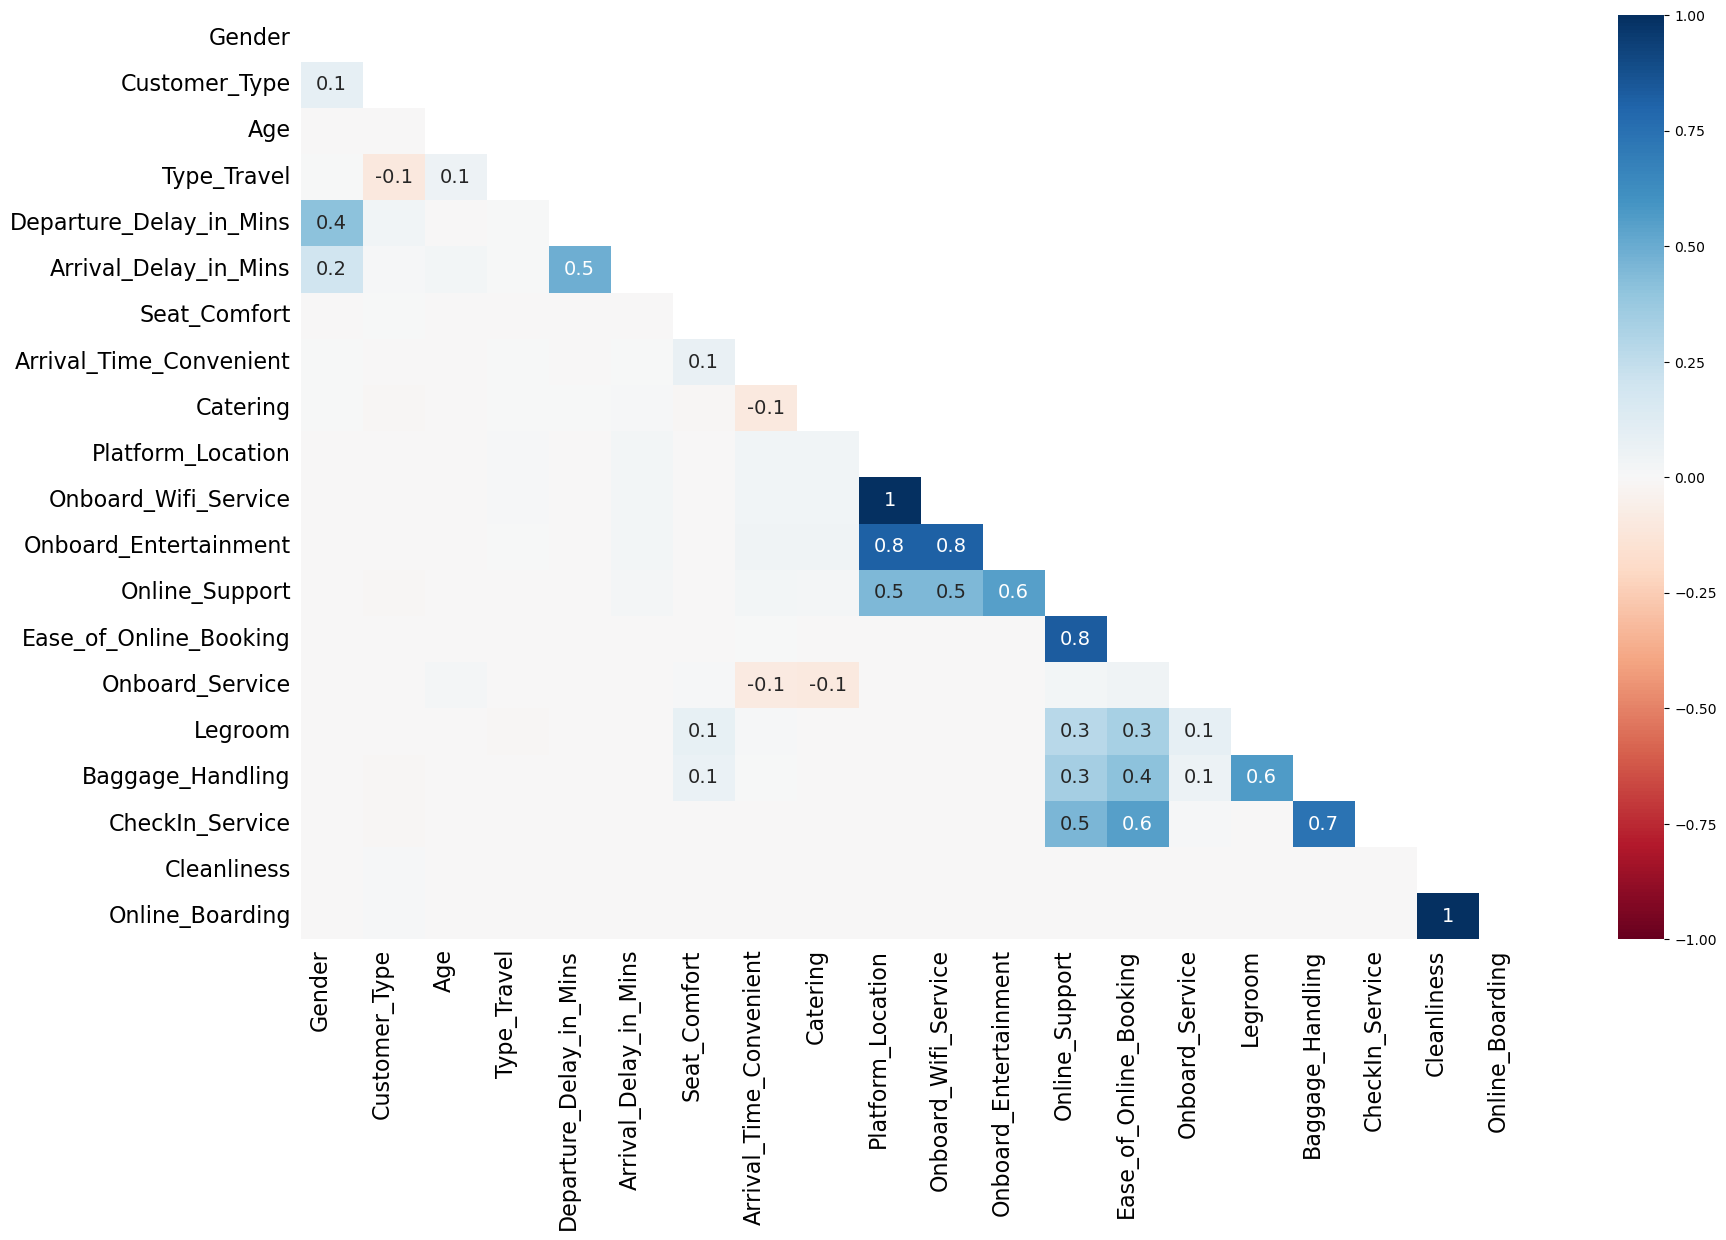

In [17]:
# Check the test dataset as well to see whether the same patterns show 
# To analyze the nullity correlation (how strongly the presence or absence of one variable affects the presence of another)
plt.figure(figsize=(12,6))  # Adjust the size as needed
msno.heatmap(encoded_test_df)
plt.xticks(rotation=90)  # Rotate x-axis labels to 90 degrees
plt.show()  # Display the plot


The missing value correlation matrix resembles a lot the train data before dropping the outlier IDs with missing values.

**Should not eliminate any data from the train_df since it's not allowed to eliminate the data on the test_df**

In [18]:
# Count the missing values in train_df
encoded_train_df.isna().sum()

ID                            0
Gender                       77
Customer_Type              8951
Age                          33
Type_Travel                9226
Travel_Class                  0
Travel_Distance               0
Departure_Delay_in_Mins      57
Arrival_Delay_in_Mins       357
Overall_Experience            0
Seat_Comfort                 61
Seat_Class                    0
Arrival_Time_Convenient    8930
Catering                   8741
Platform_Location            30
Onboard_Wifi_Service         30
Onboard_Entertainment        18
Online_Support               91
Ease_of_Online_Booking       73
Onboard_Service            7601
Legroom                      90
Baggage_Handling            142
CheckIn_Service              77
Cleanliness                   6
Online_Boarding               6
dtype: int64

In [19]:
# Count the missing values in test_df
encoded_test_df.isna().sum()

ID                            0
Gender                       30
Customer_Type              3383
Age                          11
Type_Travel                3448
Travel_Class                  0
Travel_Distance               0
Departure_Delay_in_Mins      29
Arrival_Delay_in_Mins       123
Seat_Comfort                 22
Seat_Class                    0
Arrival_Time_Convenient    3325
Catering                   3357
Platform_Location            12
Onboard_Wifi_Service         12
Onboard_Entertainment         8
Online_Support               26
Ease_of_Online_Booking       18
Onboard_Service            2872
Legroom                      25
Baggage_Handling             40
CheckIn_Service              22
Cleanliness                   2
Online_Boarding               2
dtype: int64

### Ideas on Advanced Imputation

#### 1. Multiple Imputation
- **Best Use Case:** Works well when the missing data mechanism is not completely random and when the missing values can be reasonably predicted from other available data in the dataset. It's particularly effective in handling uncertainty in the imputation process and provides a robust way to estimate missing values by incorporating variability in the imputations.
- **Advantages:** It helps account for the uncertainty of the imputation, providing a more statistically valid approach, which can be crucial in inferential statistics and scenarios requiring robust error estimates.
- **Accuracy:** Generally provides high accuracy and reliability, especially in datasets where the missingness relates to the values of other variables.

#### 2. K-Nearest Neighbors (KNN) Imputation
- **Best Use Case:** Most effective when there are clear clusters or groups in the data, and the data points within each group or cluster are similar. It assumes that the way to predict the value of a missing data point is to look at the most similar available data points.
- **Advantages:** Simple and effective, especially if the dataset has meaningful clusters. The assumption that 'similar cases have similar properties' can be very powerful in practical applications.
- **Accuracy:** Can be very accurate in datasets with strong local correlations but might suffer if the dimensionality is high or if the local structure is weak.

#### 3. Regression Imputation
- **Best Use Case:** Suitable when a strong linear or nonlinear relationship exists between the variable with missing data and other variables. Regression models can exploit this relationship to predict missing values.
- **Advantages:** Leverages existing relationships in the data for predictions, which can be more accurate than basic imputation methods if the model correctly captures the underlying patterns.
- **Accuracy:** Accuracy depends on how well the regression model fits the data. Overfitting or underfitting can significantly affect performance, and it may not account for the uncertainty inherent in the imputation.

#### Decision Factors:
- **Data Size and Quality:** Regression and KNN can be sensitive to the size and quality of the data. Regression may not perform well if the predictors do not have a strong relationship with the target variable. KNN requires a sufficiently large sample size to find meaningful neighbors.
- **Missing Data Mechanism:** If the data are missing at random (MAR) or missing completely at random (MCAR), multiple imputation can be particularly effective. If the pattern of missingness is related to the missing values themselves (not at random, MNAR), then more sophisticated approaches or careful adjustments in regression models might be needed.
- **Computational Resources:** Multiple imputation and KNN are computationally intensive compared to simpler methods, which might be a consideration depending on the environment in which you are working.



In [20]:
def find_highly_correlated_missing_values(df, threshold=0.7):
    """
    Identifies and returns pairs of columns with high correlation in missing values.

    Parameters:
        df (pandas.DataFrame): The DataFrame to analyze.
        threshold (float): The minimum absolute correlation value to consider. Defaults to 0.7.

    Returns:
        list of tuples: A list containing tuples of the column pairs and their correlation values.
    """
    if not isinstance(df, pd.DataFrame):
        raise ValueError("Input must be a pandas DataFrame.")

    # Calculate the missing data correlation matrix
    missing_corr = df.isnull().corr()

    # Find pairs with high absolute correlation
    high_corr_pairs = []
    for i in range(len(missing_corr.columns)):
        for j in range(i+1, len(missing_corr.columns)):
            if abs(missing_corr.iloc[i, j]) >= threshold:
                high_corr_pairs.append((missing_corr.columns[i], missing_corr.columns[j], missing_corr.iloc[i, j]))

    return high_corr_pairs


In [21]:
high_corr_pairs_train = find_highly_correlated_missing_values(encoded_train_df, threshold=0.7)
for pair in high_corr_pairs_train:
    print(f"{pair[0]} and {pair[1]} have a missing value correlation of {pair[2]:.2f}")

Platform_Location and Onboard_Wifi_Service have a missing value correlation of 1.00
Platform_Location and Onboard_Entertainment have a missing value correlation of 0.77
Onboard_Wifi_Service and Onboard_Entertainment have a missing value correlation of 0.77
Online_Support and Ease_of_Online_Booking have a missing value correlation of 0.90
Baggage_Handling and CheckIn_Service have a missing value correlation of 0.74
Cleanliness and Online_Boarding have a missing value correlation of 1.00


In [22]:
high_corr_pairs_test = find_highly_correlated_missing_values(encoded_test_df, threshold=0.7)
for pair in high_corr_pairs_test:
    print(f"{pair[0]} and {pair[1]} have a missing value correlation of {pair[2]:.2f}")

Platform_Location and Onboard_Wifi_Service have a missing value correlation of 1.00
Platform_Location and Onboard_Entertainment have a missing value correlation of 0.82
Onboard_Wifi_Service and Onboard_Entertainment have a missing value correlation of 0.82
Online_Support and Ease_of_Online_Booking have a missing value correlation of 0.83
Baggage_Handling and CheckIn_Service have a missing value correlation of 0.74
Cleanliness and Online_Boarding have a missing value correlation of 1.00


In [23]:
#Check the missing values in Platform_Location and Onboard_Wifi_Service
encoded_train_df.loc[encoded_train_df['Platform_Location'].isna()]['Onboard_Wifi_Service']

2215    NaN
4477    NaN
6694    NaN
8775    NaN
14620   NaN
15271   NaN
17607   NaN
22867   NaN
29893   NaN
32086   NaN
35373   NaN
37897   NaN
41688   NaN
45382   NaN
47006   NaN
53010   NaN
53500   NaN
56497   NaN
59270   NaN
59964   NaN
62201   NaN
62699   NaN
66959   NaN
69915   NaN
70266   NaN
76005   NaN
84335   NaN
85184   NaN
89394   NaN
91055   NaN
Name: Onboard_Wifi_Service, dtype: float64

In [24]:
#Check the missing values in Platform_Location and Online_Boarding
encoded_train_df.loc[encoded_train_df['Cleanliness'].isna()]['Online_Boarding']

3210    NaN
29045   NaN
48087   NaN
65681   NaN
79256   NaN
88733   NaN
Name: Online_Boarding, dtype: float64

In [25]:
def check_missing_data_by_id(df, columns):
    """
    Check if missing values in specified columns are attributed to the same IDs.

    Parameters:
        df (DataFrame): The pandas DataFrame containing the data.
        columns (list): List of column names to check for missing value correlation.

    Returns:
        DataFrame: A DataFrame containing counts of missing values per ID.
    """
    # Create a new DataFrame to hold missing value information
    missing_info = df[columns].isnull()
    
    # Sum the number of missing values in the specified columns per row
    missing_info['missing_count'] = missing_info.sum(axis=1)
    
    # Add ID column to missing_info DataFrame for grouping
    missing_info['ID'] = df['ID']
    
    # Group by 'ID' and sum missing counts
    grouped_missing = missing_info.groupby('ID')['missing_count'].sum()
    
    # Sort the results by missing count in descending order to see the IDs with the most missing values
    grouped_missing = grouped_missing.sort_values(ascending=False)
    
    return grouped_missing

# Columns to check
columns_to_check = ['Platform_Location', 'Onboard_Wifi_Service', 'Onboard_Entertainment', 
                    'Online_Support', 'Ease_of_Online_Booking', 'Baggage_Handling', 
                    'CheckIn_Service', 'Cleanliness', 'Online_Boarding']

# Calling the function
missing_data_by_id = check_missing_data_by_id(encoded_train_df, columns_to_check)
print(missing_data_by_id.loc[missing_data_by_id != 0])


ID
98847007    6
98884799    4
98810657    4
98876006    4
98817365    4
           ..
98831098    1
98879167    1
98874460    1
98820665    1
98834590    1
Name: missing_count, Length: 200, dtype: int64


### Step 2, 3, 4: Handling Missing Data

In [26]:
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

def calculate_missingness_correlation(df):
    """Calculate the correlation of missingness between each pair of variables in the DataFrame."""
    missingness = df.isnull().astype(int)
    missing_corr = missingness.corr()
    return missing_corr

def find_groups(corr_matrix, threshold=0.7, exclude_self=True):
    """Identify groups of variables with high correlation, either in missingness or actual values."""
    groups = []
    used = set()
    for col in corr_matrix.columns:
        if col in used:
            continue
        correlated = corr_matrix.index[corr_matrix[col] > threshold].tolist()
        if exclude_self:
            correlated.remove(col)  # Remove self correlation for value correlation groups
        if correlated:
            group = [col] + correlated
            groups.append(group)
            used.update(group)
    return groups

def handle_simultaneous_missingness(df, groups):
    """Apply imputation methods suitable for variables that often miss together."""
    for group in groups:
        # Use IterativeImputer as it can model complex interactions even in the presence of missing data
        imputer = IterativeImputer(estimator=RandomForestRegressor(n_estimators=50, random_state=42), max_iter=10, random_state=42)
        df[group] = imputer.fit_transform(df[group])
    return df

def handle_group_imputation(df, group, data_types):
    """Perform initial and predictive imputation for a group of correlated variables."""
    # Initial Simple Imputation
    for col in group:
        if data_types.get(col, 'numeric') == 'categorical':
            df[col].fillna(df[col].mode()[0], inplace=True)
        else:
            df[col].fillna(df[col].median(), inplace=True)

    # Predictive Imputation using RandomForest
    for col in group:
        predictors = list(set(group) - set([col]))
        if not df[predictors].dropna().empty:  # Ensure there are enough data points
            known_mask = df[col].notna()
            unknown_mask = df[col].isna()
            if known_mask.any() and unknown_mask.any():
                if data_types.get(col, 'numeric') == 'categorical':
                    model = RandomForestClassifier(n_estimators=100, random_state=42)
                else:
                    model = RandomForestRegressor(n_estimators=100, random_state=42)
                model.fit(df.loc[known_mask, predictors], df.loc[known_mask, col])
                df.loc[unknown_mask, col] = model.predict(df.loc[unknown_mask, predictors])
    return df

def comprehensive_iterative_imputation(df):
    """Apply comprehensive iterative imputation across the entire DataFrame."""
    iter_imp = IterativeImputer(estimator=RandomForestRegressor(n_estimators=10), random_state=42, max_iter=10)
    df[:] = iter_imp.fit_transform(df)
    return df

def handle_missing_data(df, data_types):
    """Integrate all steps to handle missing data in the dataset."""
    # Step 1: Calculate missingness correlations
    miss_corr_matrix = calculate_missingness_correlation(df)
    simultaneous_groups = find_groups(miss_corr_matrix, threshold=0.7, exclude_self=False)
    df = handle_simultaneous_missingness(df, simultaneous_groups)
    
    # Step 2: Correlation analysis for handling correlated data groups
    value_corr_matrix = df.corr()
    value_groups = find_groups(value_corr_matrix, threshold=0.5)
    for group in value_groups:
        df = handle_group_imputation(df, group, data_types)
    
    # Step 3: Apply comprehensive iterative imputation
    df = comprehensive_iterative_imputation(df)
    
    return df


In [27]:
# Drop the overall experience to avoid contamination 
X_train = encoded_train_df.drop(columns='Overall_Experience', axis=1)
X_train.head()

,ID,Gender,Customer_Type,Age,Type_Travel,Travel_Class,Travel_Distance,Departure_Delay_in_Mins,Arrival_Delay_in_Mins,Seat_Comfort,...,Onboard_Wifi_Service,Onboard_Entertainment,Online_Support,Ease_of_Online_Booking,Onboard_Service,Legroom,Baggage_Handling,CheckIn_Service,Cleanliness,Online_Boarding
0,98800001,0.0,1.0,52.0,NaN,0,272,0.0,5.0,2.0,...,4.0,2.0,3.0,2.0,2.0,3.0,2.0,4.0,2.0,1.0
1,98800002,1.0,1.0,48.0,1.0,1,2200,9.0,0.0,1.0,...,4.0,1.0,4.0,4.0,5.0,2.0,1.0,2.0,4.0,4.0
2,98800003,0.0,1.0,43.0,0.0,0,1061,77.0,119.0,2.0,...,2.0,4.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0,5.0
3,98800004,0.0,1.0,44.0,0.0,0,780,13.0,18.0,3.0,...,3.0,2.0,3.0,3.0,3.0,3.0,3.0,4.0,3.0,3.0
4,98800005,0.0,1.0,50.0,0.0,0,1981,0.0,0.0,3.0,...,2.0,4.0,5.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0


In [28]:
data_types = {
    'ID': 'numeric',  # A unique identifier for each passenger
    'Platform_Location': 'categorical',
    'Seat_Class': 'categorical',
    'Seat_Comfort': 'categorical',
    'Arrival_Time_Convenient': 'categorical',
    'Catering': 'categorical',
    'Onboard_Wifi_Service': 'categorical',
    'Onboard_Entertainment': 'categorical',
    'Online_Support': 'categorical',
    'Ease_of_Online_Booking': 'categorical',
    'Onboard_Service': 'categorical',
    'Legroom': 'categorical',
    'Baggage_Handling': 'categorical',
    'CheckIn_Service': 'categorical',
    'Cleanliness': 'categorical',
    'Online_Boarding': 'categorical',
    'Gender': 'categorical',
    'Customer_Type': 'categorical',
    'Age': 'numeric',
    'Type_Travel': 'categorical',
    'Travel_Class': 'categorical',
    'Travel_Distance': 'numeric',
    'Departure_Delay_in_Mins': 'numeric',
    'Arrival_Delay_in_Mins': 'numeric'
}


In [29]:
# Non-missing value data sets 
X_train_no_miss = handle_missing_data(X_train, data_types)
Y_train = encoded_train_df['Overall_Experience']
X_test_no_miss = handle_missing_data(encoded_test_df, data_types)

In [30]:
X_train_no_miss

,ID,Gender,Customer_Type,Age,Type_Travel,Travel_Class,Travel_Distance,Departure_Delay_in_Mins,Arrival_Delay_in_Mins,Seat_Comfort,...,Onboard_Wifi_Service,Onboard_Entertainment,Online_Support,Ease_of_Online_Booking,Onboard_Service,Legroom,Baggage_Handling,CheckIn_Service,Cleanliness,Online_Boarding
0,98800001,0.0,1.0,52.0,0.0,0,272,0.0,5.0,2.0,...,4.0,2.0,3.0,2.0,2.0,3.0,2.0,4.0,2.0,1.0
1,98800002,1.0,1.0,48.0,1.0,1,2200,9.0,0.0,1.0,...,4.0,1.0,4.0,4.0,5.0,2.0,1.0,2.0,4.0,4.0
2,98800003,0.0,1.0,43.0,0.0,0,1061,77.0,119.0,2.0,...,2.0,4.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0,5.0
3,98800004,0.0,1.0,44.0,0.0,0,780,13.0,18.0,3.0,...,3.0,2.0,3.0,3.0,3.0,3.0,3.0,4.0,3.0,3.0
4,98800005,0.0,1.0,50.0,0.0,0,1981,0.0,0.0,3.0,...,2.0,4.0,5.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94374,98894375,1.0,1.0,32.0,0.0,0,1357,83.0,125.0,1.0,...,1.0,1.0,1.0,1.0,4.0,4.0,4.0,2.0,4.0,1.0
94375,98894376,1.0,1.0,44.0,0.0,0,592,5.0,11.0,4.0,...,2.0,5.0,5.0,3.0,3.0,3.0,3.0,4.0,3.0,4.0
94376,98894377,1.0,1.0,63.0,0.0,0,2794,0.0,0.0,2.0,...,4.0,5.0,4.0,4.0,4.0,4.0,4.0,3.0,4.0,3.0
94377,98894378,1.0,1.0,16.0,1.0,1,2744,0.0,0.0,2.0,...,4.0,2.0,4.0,4.0,3.0,4.0,4.0,4.0,5.0,4.0


In [31]:
X_train_no_miss.isna().sum()

ID                         0
Gender                     0
Customer_Type              0
Age                        0
Type_Travel                0
Travel_Class               0
Travel_Distance            0
Departure_Delay_in_Mins    0
Arrival_Delay_in_Mins      0
Seat_Comfort               0
Seat_Class                 0
Arrival_Time_Convenient    0
Catering                   0
Platform_Location          0
Onboard_Wifi_Service       0
Onboard_Entertainment      0
Online_Support             0
Ease_of_Online_Booking     0
Onboard_Service            0
Legroom                    0
Baggage_Handling           0
CheckIn_Service            0
Cleanliness                0
Online_Boarding            0
dtype: int64

In [35]:
X_test_no_miss.isna().sum()

ID                         0
Gender                     0
Customer_Type              0
Age                        0
Type_Travel                0
Travel_Class               0
Travel_Distance            0
Departure_Delay_in_Mins    0
Arrival_Delay_in_Mins      0
Seat_Comfort               0
Seat_Class                 0
Arrival_Time_Convenient    0
Catering                   0
Platform_Location          0
Onboard_Wifi_Service       0
Onboard_Entertainment      0
Online_Support             0
Ease_of_Online_Booking     0
Onboard_Service            0
Legroom                    0
Baggage_Handling           0
CheckIn_Service            0
Cleanliness                0
Online_Boarding            0
dtype: int64

In [32]:
def check_imputation_difference(original_df, new_df):
    # Ensure the dataframes are aligned
    if not original_df.index.equals(new_df.index) or not original_df.columns.equals(new_df.columns):
        raise ValueError("The DataFrames' indices or columns do not match.")
    
    # Create a mask for non-missing values in the original DataFrame
    non_missing_mask = ~original_df.isnull()
    
    # Compare the original and new dataframes where the original data was not missing
    unchanged_data_mask = (original_df[non_missing_mask] == new_df[non_missing_mask])
    
    # If any value has changed, it will be False in the mask
    if not unchanged_data_mask.all().all():
        # Identify where the changes have occurred
        changes = unchanged_data_mask[~unchanged_data_mask]
        changed_indices = changes.stack().index.tolist()
        print(f"Changes detected at the following locations: {changed_indices}")
        return False
    else:
        print("No changes detected in the non-missing data.")
        return True


In [33]:
check_imputation_difference(X_train, X_train_no_miss)

No changes detected in the non-missing data.


True

In [34]:
check_imputation_difference(encoded_test_df, X_test_no_miss)

No changes detected in the non-missing data.


True

In [36]:
# Non-missing value data sets saved to csv
X_train_no_miss.to_csv('X_train_no_miss.csv', index=False)
Y_train.to_csv('Y_train.csv', index=False)
X_test_no_miss.to_csv('X_test_no_miss.csv', index=False)

In [37]:
pd.read_csv('X_train_no_miss.csv')

,ID,Gender,Customer_Type,Age,Type_Travel,Travel_Class,Travel_Distance,Departure_Delay_in_Mins,Arrival_Delay_in_Mins,Seat_Comfort,...,Onboard_Wifi_Service,Onboard_Entertainment,Online_Support,Ease_of_Online_Booking,Onboard_Service,Legroom,Baggage_Handling,CheckIn_Service,Cleanliness,Online_Boarding
0,98800001,0.0,1.0,52.0,0.0,0,272,0.0,5.0,2.0,...,4.0,2.0,3.0,2.0,2.0,3.0,2.0,4.0,2.0,1.0
1,98800002,1.0,1.0,48.0,1.0,1,2200,9.0,0.0,1.0,...,4.0,1.0,4.0,4.0,5.0,2.0,1.0,2.0,4.0,4.0
2,98800003,0.0,1.0,43.0,0.0,0,1061,77.0,119.0,2.0,...,2.0,4.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0,5.0
3,98800004,0.0,1.0,44.0,0.0,0,780,13.0,18.0,3.0,...,3.0,2.0,3.0,3.0,3.0,3.0,3.0,4.0,3.0,3.0
4,98800005,0.0,1.0,50.0,0.0,0,1981,0.0,0.0,3.0,...,2.0,4.0,5.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94374,98894375,1.0,1.0,32.0,0.0,0,1357,83.0,125.0,1.0,...,1.0,1.0,1.0,1.0,4.0,4.0,4.0,2.0,4.0,1.0
94375,98894376,1.0,1.0,44.0,0.0,0,592,5.0,11.0,4.0,...,2.0,5.0,5.0,3.0,3.0,3.0,3.0,4.0,3.0,4.0
94376,98894377,1.0,1.0,63.0,0.0,0,2794,0.0,0.0,2.0,...,4.0,5.0,4.0,4.0,4.0,4.0,4.0,3.0,4.0,3.0
94377,98894378,1.0,1.0,16.0,1.0,1,2744,0.0,0.0,2.0,...,4.0,2.0,4.0,4.0,3.0,4.0,4.0,4.0,5.0,4.0


In [40]:
final_corr_matrix = X_train_no_miss.corr()
final_corr_matrix

,ID,Gender,Customer_Type,Age,Type_Travel,Travel_Class,Travel_Distance,Departure_Delay_in_Mins,Arrival_Delay_in_Mins,Seat_Comfort,...,Onboard_Wifi_Service,Onboard_Entertainment,Online_Support,Ease_of_Online_Booking,Onboard_Service,Legroom,Baggage_Handling,CheckIn_Service,Cleanliness,Online_Boarding
ID,1.000000,0.001620,0.002238,-0.002573,-0.002060,0.003185,0.000878,-0.000448,0.000977,0.002597,...,0.001097,0.004193,0.000350,-0.001528,-0.002858,-0.000817,0.001137,-0.003239,-0.002127,-0.002533
Gender,0.001620,1.000000,0.027860,0.005035,0.011197,-0.009196,0.126043,0.002065,0.000093,-0.072147,...,-0.032131,-0.142193,-0.091215,-0.083110,-0.055194,-0.071708,-0.014813,-0.016195,-0.015903,-0.047220
Customer_Type,0.002238,0.027860,1.000000,0.265039,0.270239,-0.078608,-0.018999,-0.002750,-0.004135,0.035775,...,0.070767,0.218200,0.174062,0.142731,0.076698,0.091676,-0.001716,0.038900,0.002041,0.101901
Age,-0.002573,0.005035,0.265039,1.000000,-0.040176,-0.136803,-0.251517,-0.007970,-0.010589,0.007994,...,0.011537,0.131479,0.117290,0.068903,0.060390,0.082667,-0.018023,0.028654,-0.018468,0.035608
Type_Travel,-0.002060,0.011197,0.270239,-0.040176,1.000000,0.512995,-0.114299,-0.008272,-0.008167,0.013539,...,-0.014304,-0.074647,-0.031940,-0.021880,0.035783,0.011413,0.046256,0.054436,0.055427,-0.004808
Travel_Class,0.003185,-0.009196,-0.078608,-0.136803,0.512995,1.000000,-0.165618,0.007314,0.012322,0.032533,...,-0.061272,-0.247824,-0.182712,-0.132335,-0.158037,-0.132203,-0.128855,-0.139735,-0.123300,-0.100726
Travel_Distance,0.000878,0.126043,-0.018999,-0.251517,-0.114299,-0.165618,1.000000,0.114134,0.111076,-0.045098,...,0.010112,-0.028173,-0.033172,-0.023012,-0.031050,-0.030418,0.019181,0.002594,0.007209,0.006168
Departure_Delay_in_Mins,-0.000448,0.002065,-0.002750,-0.007970,-0.008272,0.007314,0.114134,1.000000,0.959922,-0.025224,...,-0.032598,-0.030369,-0.033305,-0.037047,-0.033875,0.000381,-0.012745,-0.020923,-0.066798,-0.019978
Arrival_Delay_in_Mins,0.000977,0.000093,-0.004135,-0.010589,-0.008167,0.012322,0.111076,0.959922,1.000000,-0.026859,...,-0.035111,-0.033112,-0.035683,-0.040274,-0.036881,-0.003042,-0.017569,-0.024088,-0.071978,-0.021922
Seat_Comfort,0.002597,-0.072147,0.035775,0.007994,0.013539,0.032533,-0.045098,-0.025224,-0.026859,1.000000,...,0.127767,0.425321,0.117952,0.209745,0.118924,0.136586,0.118228,0.041225,0.108168,0.128751


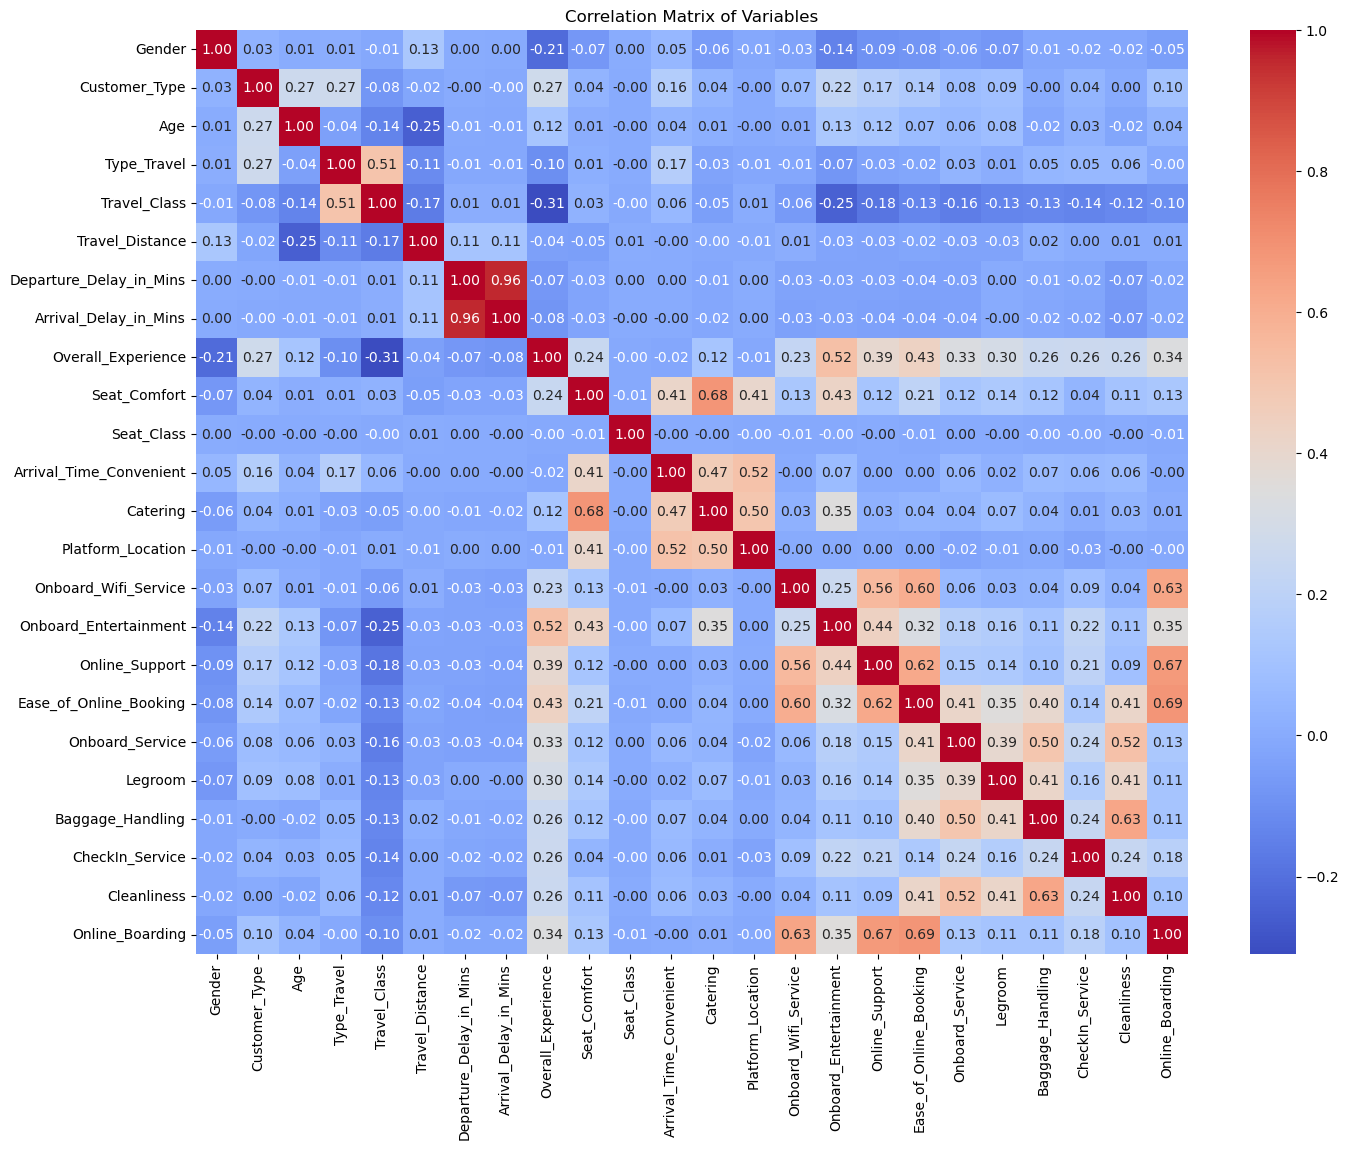

In [41]:
# Plotting the heatmap of the correlation matrix - before imputation
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix_train, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of Variables')
plt.show()


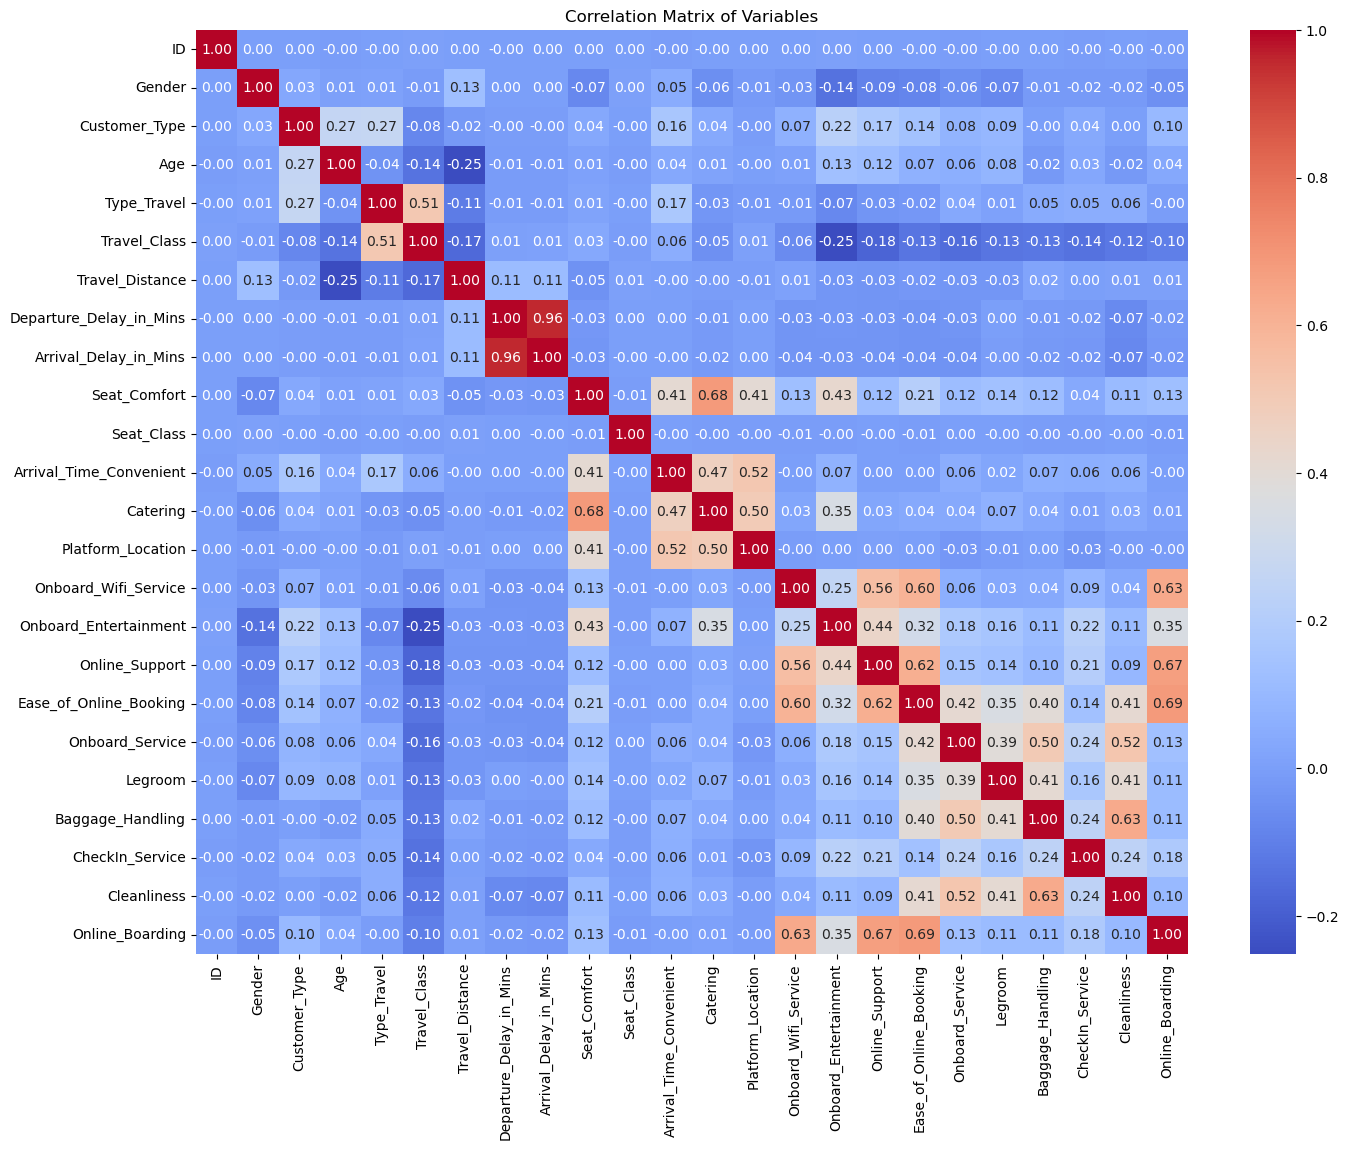

In [42]:
# Plotting the heatmap of the correlation matrix
plt.figure(figsize=(16, 12))
sns.heatmap(final_corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of Variables')
plt.show()


Based on the heatmap of the data before and after imputation, we can see that the imputation method used preserved the correlation among variables. If the correlation matrix of the imputed data closely resembles that of the pre-imputed data, that's generally a positive sign. It suggests that the imputation process preserved the underlying relationships between variables, which is often a goal of effective imputation.

In [43]:
# See the info
X_train_no_miss.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94379 entries, 0 to 94378
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       94379 non-null  int64  
 1   Gender                   94379 non-null  float64
 2   Customer_Type            94379 non-null  float64
 3   Age                      94379 non-null  float64
 4   Type_Travel              94379 non-null  float64
 5   Travel_Class             94379 non-null  int64  
 6   Travel_Distance          94379 non-null  int64  
 7   Departure_Delay_in_Mins  94379 non-null  float64
 8   Arrival_Delay_in_Mins    94379 non-null  float64
 9   Seat_Comfort             94379 non-null  float64
 10  Seat_Class               94379 non-null  int64  
 11  Arrival_Time_Convenient  94379 non-null  float64
 12  Catering                 94379 non-null  float64
 13  Platform_Location        94379 non-null  float64
 14  Onboard_Wifi_Service  